In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE_plus


In [2]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import seaborn as sns
import plotly.express as px

from experiments.evaluation.evaluation_utils import load_dataset_for_eval, calculate_metrics_for_dataset, calculate_metrics_for_dataset_mp

print(tf.__version__)

2.13.0


In [138]:
# DATASETS = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = [
    "BasicMotions", "NATOPS", "UWaveGestureLibrary",
    'ArticularyWordRecognition', 'Cricket', 'Epilepsy', 'PenDigits', 
    # 'PEMS-SF',
    'RacketSports', 'SelfRegulationSCP1'
]
MO_UTILITY = np.array([0.1, 0.4*0.7, 0.6*0.7, 0.2])
model_to_explain = "cls_basic_train"
osc_names = {"AE": "ae_basic_train", "IF": "if_basic_train", "LOF": "lof_basic_train"}
methods = {
    # Comparison between single objective and multi objective ordered by same weights
    # "comte": "COMTE",
    # "abcf": "AB-CF",
    # "discox": "DiscoX",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "MultiSub-SpaCE", # ("multisubspace_gknn_75_0_25_prmut05")
    
    # "abd6be72d2e5c0967af2134fe463ff2ad9250524": "Sub-SpaCE",
    # "7dbaa6cfdb5cd23ba93e6495b43a5f2874fd79c0": "multisubspace_gknn_75_25_0",
    # "b4a4daf2c1791e984fb1ec07dfe589ddf9caf4bb": "multisubspace_gknn_cch_55_100",
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25",

    # Compparison between pruning incorporated in the process vs 25 iterations of only prunning
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25",
    # "5f46fc7707574df97f58cbdea5a22eb059521b8d": "integrated_prunning_gknn_0_100_0",

    # Comparison between initialization
    # "827e5a1dcdef171654915c3a6044f696b45907f5": "multisubspace_gknn_75_0_25_fi_none",
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25_fi_gradcam",

    # New mutation experiments (fi none)
    # "98115f1aa11842ba52440c2efcae5b9f5dad10f2": "multisubspace_gknn_75_0_25_mut01",
    # "afd19a8e19ebb2a3aa36f377a7ed81f0c2d55f16": "multisubspace_gknn_75_0_25_mut02",
    # "1cf037d1e4512683b378b90ee9345de26d09def6": "multisubspace_gknn_75_0_25_mut03",
    # "e04c4795bf5b47b47d660f78ff50f2038e16fdfd": "multisubspace_gknn_75_0_25_mut04",
    # "2f59f6a9fb383e5e87357b4c64b422836b2921a6": "multisubspace_gknn_75_0_25_mut05",
    # "565064e37e308e5881221745d22763d8fa51b37a": "multisubspace_gknn_75_0_25_mut06",
    # "9c3070b31c45e8f9197e4fb4f62e9e02cb687b45": "multisubspace_gknn_75_0_25_mut07",
    # "d06c42645d15ba3573722b600ebbf593455ef748": "multisubspace_gknn_75_0_25_mut08",
    # "e87b5e0754f69e5d00651bc87a34567cf82fe6e3": "multisubspace_gknn_75_0_25_mut09",

    # New mutation experiments pruning (fi none)
    # "19f0de6299f82c9ab47d1d46c6ea83ee54dfe691": "multisubspace_gknn_75_0_25_prmut005",
    # "4aafe4d4ccb244b2446d66b8608600205b942787": "multisubspace_gknn_75_0_25_prmut01",
    # "a237cc2d28cfe6f9add64a179b2fa7b4d747853a": "multisubspace_gknn_75_0_25_prmut02",
    # "e9ebdff05a145a76c31f2cbe438e1a32e5c5473a": "multisubspace_gknn_75_0_25_prmut03",
    # "a33c5446ce679cedb83991068c270831efa47975": "multisubspace_gknn_75_0_25_prmut04",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "multisubspace_gknn_75_0_25_prmut05",
    # "9e9a7a01b4824d2f58291cc086174576a5dcbcfe": "multisubspace_gknn_75_0_25_prmut06",
    # "ac7c5b42b1036baf33e912ab9a9613893cd6b843": "multisubspace_gknn_75_0_25_prmut07",
    # "89092d7641759abfb5841f049b37396865a9d775": "multisubspace_gknn_75_0_25_prmut08",
    # "4c06abd19829ede45f8c5bc3c958b0b3a3a2d6db": "multisubspace_gknn_75_0_25_prmut09",

    # New mutation experiments (Common mask) with integrated pruning (fi none)
    # "ac204888fafaadc5282a78c1df9e343fc4992be4": "multisubspace_100_0_0_ecmut01",
    # "8dd39d47a9f387f7f5fb34a4a0528123c54322ea": "multisubspace_100_0_0_ecmut025",
    # "ab2a366f7a19ecb9649ec7e1e9c5e1db2a233a1d": "multisubspace_100_0_0_ecmut05",
    # "ffc3071aa361488419da609865a6727d87e5fb90": "multisubspace_100_0_0_ecmut075",
    # "c427cd5052d27580e00284752bcc157518ae0b28": "multisubspace_100_0_0_ecmut09",

    # New mutation experiments (Independent mask) with integrated pruning (fi none)
    # "fd3f4639ac8ceb7d91b0e47ab79bb8bdc362d24f": "multisubspace_0_100_0_ecmut01",
    # "2d9146728a5a7f7e25de2083027e2baecbfa6ee3": "multisubspace_0_100_0_ecmut025",
    # "ab7a867102b50f24504b7ad92da408fd9a9b563f": "multisubspace_0_100_0_ecmut05",
    # "54f4511bb0757603c324467b840479ea0284a7f9": "multisubspace_0_100_0_ecmut075",
    # "b3b6bdcf5cad49af48dbe493980aeeae6914fc47": "multisubspace_0_100_0_ecmut09",

    # New mutation experiments (Common mask) with integrated pruning (fi none)
    # "a637bc423783498d207e9dda3ab7dbd731e9a5e1": "multisubspace_100_0_0_iprmut005",
    # "6e26a9c3971ebd6650c3a13fec84ce2da94745d2": "multisubspace_100_0_0_iprmut01",
    # "212b6d7f7b13032dd640af18818a8f386a13fda0": "multisubspace_100_0_0_iprmut02",
    # # "94b669c9b61bed442ecb15ed4d5990bab047af16": "multisubspace_100_0_0_iprmut025",
    # "bb352a5c349c64faa6826ed76fe99689596491f8": "multisubspace_100_0_0_iprmut035",
    # "1f3f4ad4573e92f66866a087631235a41bfc0c12": "multisubspace_100_0_0_iprmut05",
    # # "7d18ae015ce34b6a1d9b402ebae814153fda14c5": "multisubspace_100_0_0_iprmut075",
    # # "cfe0077fd88ca25ad3f27b263bb971e27f964fc9": "multisubspace_100_0_0_iprmut09",

    # New mutation experiments (Independent mask) with integrated pruning (fi none)
    # "2603d798caf49ed7564030ae33fbfeac8b7dad78": "multisubspace_0_100_0_iprmut005",
    # "7f4ad301ee140fe43babd635f92dfe874b87e577": "multisubspace_0_100_0_iprmut01",
    # "58c2870a9a8e2384f28153f7c27d4135b4356bb1": "multisubspace_0_100_0_iprmut02",
    # "d53b1be50eaa09837716d4bcbf3e3754d54903a3": "multisubspace_0_100_0_iprmut035",
    # "d7e242f837d82cdf400b6c65818c8c6fea4f7270": "multisubspace_0_100_0_iprmut05",

    # Comparison between best of E/C & pruning mutations
    # "ffc3071aa361488419da609865a6727d87e5fb90": "100_0_0_ec075_ipr0",
    # "ab7a867102b50f24504b7ad92da408fd9a9b563f": "0_100_0_ec05_ipr0",
    # "a637bc423783498d207e9dda3ab7dbd731e9a5e1": "100_0_0_ec075_ipr005",
    # "2603d798caf49ed7564030ae33fbfeac8b7dad78": "0_100_0_iprmut005",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "MultiSub-SpaCE", # ("multisubspace_gknn_75_0_25_prmut05")

    # Comparison with 25 it of only pruning
    # "29b9dbe13de445c2cf8ea00fedca97b1b648e5aa": "75_0_25_ec075_ipr_0_fpr_005",
    # "3f834c1186aa270c6048ebf6f554698a9e2d12c7": "75_0_25_ec075_ipr_0_fpr_01",
    # "1dad377cc1a12782510d102d1c1ba6a529b8328a": "75_0_25_ec075_ipr_0_fpr_015",
    # "f306113d525e21cafe4a57365425dc791bba67cd": "75_0_25_ec075_ipr_0_fpr_025",
    # "d8387d902c6723a9106adc62d4fc6f327a8bd275": "75_0_25_ec075_ipr_0_fpr_05",
    # "61b66d237ff204a204de3a61e134c80195dca04d": "75_0_25_ec075_ipr_0_fpr_075",
    
    # "ee364d535a0f74d80bfbdaae4d58014b6a53cf89": "0_75_25_ec05_ipr_0_fpr_005",
    # "667e1967332038ea966a6dc6860bd9500c62117b": "0_75_25_ec05_ipr_0_fpr_01",
    # "2e7f51c26996a0b7f682ee58eca8dd60f36625ae": "0_75_25_ec05_ipr_0_fpr_015",
    # "819d774d3dfea8ab007487ec88a310b5f03f5ce1": "0_75_25_ec05_ipr_0_fpr_025",
    # "63c2745444f62086373133c4e087aaa433047fd0": "0_75_25_ec05_ipr_0_fpr_05",
    # "063c34241dc3ad25f823c7fb12363691bd419f6e": "0_75_25_ec05_ipr_0_fpr_075",
    
}

# Get results

In [139]:
# Data and aux data dict
data_dict = {}
models_dict = {}
outlier_calculators_dict = {}
possible_nuns_dict = {}
desired_classes_dict = {}
original_classes_dict = {}

# Results dicts
mean_results_dict = {}
methods_cfs_dict = {}
results_all_datasets_df = pd.DataFrame()
common_test_indexes_dict = {}

# Iterate through datasets
for dataset in DATASETS:
    print(f'Calculating metrics for {dataset}')
    # Load all info needed to get the counterfactual
    data_tuple, original_classes, model, outlier_calculators, possible_nuns, desired_classes = load_dataset_for_eval(dataset, model_to_explain, osc_names)
    data_dict[dataset] = data_tuple
    models_dict[dataset] = model
    outlier_calculators_dict[dataset] = outlier_calculators
    possible_nuns_dict[dataset] = possible_nuns
    desired_classes_dict[dataset] = desired_classes
    original_classes_dict[dataset] = original_classes

    # Get the metrics for all methods
    dataset_mean_std_df, dataset_results_df, method_cfs_dataset, common_test_indexes = calculate_metrics_for_dataset(
        dataset, methods, model_to_explain,
        data_tuple, original_classes, model, outlier_calculators, possible_nuns,
        mo_weights=MO_UTILITY
    )
    mean_results_dict[dataset] = dataset_mean_std_df
    methods_cfs_dict[dataset] = method_cfs_dataset
    results_all_datasets_df = pd.concat([results_all_datasets_df, dataset_results_df])
    common_test_indexes_dict[dataset] = common_test_indexes

    # Store results
    dataset_mean_std_df.to_csv(f'./experiments/evaluation/results_mean_metrics_{dataset}.csv', sep=";", index=False)

# Store all results
results_all_datasets_df.to_csv(f'./experiments/evaluation/results_all.csv', sep=";", index=False)


Calculating metrics for BasicMotions
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:28<00:00,  3.71s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:50<00:00,  2.75s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:43<00:00,  2.59s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:04<00:00,  3.12s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:42<00:00,  2.56s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:12<00:00,  3.32s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:22<00:00,  3.57s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:47<00:00,  2.69s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:12<00:00,  3.30s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:53<00:00,  2.84s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:45<00:00,  2.65s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:49<00:00,  2.75s/it]


Calculating metrics for NATOPS
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.12s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.25s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:44<00:00,  2.84s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.25s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:28<00:00,  3.29s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.12s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:30<00:00,  3.30s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:56<00:00,  2.97s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.32s/it]


Calculating metrics for UWaveGestureLibrary
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:35<00:00,  7.55s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:43<00:00,  7.03s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:33<00:00,  7.54s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:30<00:00,  7.50s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:28<00:00,  7.48s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:26<00:00,  6.86s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:18<00:00,  7.38s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:53<00:00,  7.14s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:41<00:00,  7.02s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:38<00:00,  6.98s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:27<00:00,  6.27s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:53<00:00,  5.94s/it]


Calculating metrics for ArticularyWordRecognition
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:03<00:00,  4.84s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:30<00:00,  3.91s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:10<00:00,  4.31s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:23<00:00,  3.84s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:37<00:00,  3.98s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:35<00:00,  5.16s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:31<00:00,  4.52s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:23<00:00,  3.84s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:36<00:00,  4.56s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:50<00:00,  4.11s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:20<00:00,  3.80s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:52<00:00,  4.13s/it]


Calculating metrics for Cricket
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [29:39<00:00, 24.72s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [28:49<00:00, 24.02s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [29:34<00:00, 24.64s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [23:19<00:00, 19.44s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [29:11<00:00, 24.33s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [31:29<00:00, 26.24s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [29:09<00:00, 24.29s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [21:51<00:00, 18.22s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [31:03<00:00, 25.89s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [26:33<00:00, 22.14s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [22:01<00:00, 18.35s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [48:52<00:00, 40.73s/it]


Calculating metrics for Epilepsy
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [35:00<00:00, 21.00s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:51<00:00,  8.31s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:55<00:00,  7.75s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:50<00:00, 12.50s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:41<00:00, 10.02s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:43<00:00, 12.44s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:24<00:00, 17.65s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:40<00:00,  8.81s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:23<00:00, 10.43s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:24<00:00,  8.64s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:02<00:00,  4.22s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.14s/it]


Calculating metrics for PenDigits
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:45<00:00,  2.25s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.29s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.28s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.34s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.17s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.40s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:11<00:00,  2.51s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.49s/it]


Calculating metrics for RacketSports
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.55s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.97s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.46s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:04<00:00,  2.45s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


Calculating metrics for SelfRegulationSCP1
063c34241dc3ad25f823c7fb12363691bd419f6e


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:29<00:00,  9.89s/it]


1dad377cc1a12782510d102d1c1ba6a529b8328a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:21<00:00, 11.02s/it]


29b9dbe13de445c2cf8ea00fedca97b1b648e5aa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:02<00:00, 11.43s/it]


2e7f51c26996a0b7f682ee58eca8dd60f36625ae


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:36<00:00,  7.56s/it]


3f834c1186aa270c6048ebf6f554698a9e2d12c7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:40<00:00, 11.20s/it]


61b66d237ff204a204de3a61e134c80195dca04d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:42<00:00, 11.22s/it]


63c2745444f62086373133c4e087aaa433047fd0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:54<00:00,  9.55s/it]


667e1967332038ea966a6dc6860bd9500c62117b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:14<00:00,  7.34s/it]


7a239d2eb20bd2726abebcc9860199e66ae6cc48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:42<00:00, 11.23s/it]


819d774d3dfea8ab007487ec88a310b5f03f5ce1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:33<00:00,  8.13s/it]


ee364d535a0f74d80bfbdaae4d58014b6a53cf89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:58<00:00,  7.19s/it]


f306113d525e21cafe4a57365425dc791bba67cd


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:02<00:00, 11.42s/it]


In [140]:
from IPython.display import display
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset])

BasicMotions


method            ii         nchanges     sparsity               L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS  subsequences subsequences %          times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  19.5 ± 11.69  142.43 ± 100.37  0.24 ± 0.17    682.8 ± 771.8  65.05 ± 52.99  0.48 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.35 ± 0.22   0.73 ± 0.2  0.95 ± 0.11  0.02 ± 0.02  0.12 ± 0.15  0.21 ± 0.28    14.2 ± 9.5    0.05 ± 0.03   41.6 ± 13.52  38.22 ± 35.26
1   75_0_25_ec075_ipr_0_fpr_015  19.5 ± 11.69   129.55 ± 83.11  0.22 ± 0.14  633.02 ± 694.94  62.71 ± 50.43   0.5 ± 0.11  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2   0.73 ± 0.2  0.94 ± 0.11  0.01 ± 0.01  0.11 ± 0.14   0.2 ± 0.26   8.55 ± 3.59    0.03 ± 0.01   35.13 ± 7.61  15.02 ± 15.56
2   75_0_25_ec075_ipr_0_fpr_005  19.5 ± 11.69    138.9 ± 83.25  0.23 ± 0.14  642.21 ± 677.25  63.34 ± 50.03  0.52 ± 0.12  1.0 ± 0.0  1.0 ± 0.0   0.32 ± 0.2   0.73 ± 0.2  0.94 ± 0.12  0.01 ± 0.02  0.12 ± 0.14   0.2 ± 0.25  10.18 ± 4.01    0.03 ± 0.01   37.36 ± 8.93  15.85 ± 16.76
3   0_75_25_ec075_ipr_0_fpr_015  19.5 ± 11.69   139.38 ± 88.32  0.23 ± 0.15  685.84 ± 775.79  65.76 ± 52.42   0.48 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.35 ± 0.22   0.73 ± 0.2  0.95 ± 0.13  0.01 ± 0.02  0.12 ± 0.14  0.21 ± 0.27   13.08 ± 8.4    0.04 ± 0.03  42.27 ± 12.75  21.05 ± 30.51
4    75_0_25_ec075_ipr_0_fpr_01  19.5 ± 11.69   134.82 ± 81.21  0.22 ± 0.14   642.3 ± 694.17  63.51 ± 50.16  0.51 ± 0.13  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2   0.73 ± 0.2  0.95 ± 0.12  0.01 ± 0.02  0.12 ± 0.14   0.2 ± 0.26    9.0 ± 3.65    0.03 ± 0.01   35.86 ± 7.96  17.55 ± 20.16
5   75_0_25_ec075_ipr_0_fpr_075  19.5 ± 11.69   136.7 ± 108.32  0.23 ± 0.18  629.98 ± 696.31  61.98 ± 49.93  0.45 ± 0.08  1.0 ± 0.0  1.0 ± 0.0   0.32 ± 0.2   0.73 ± 0.2  0.94 ± 0.13  0.01 ± 0.02  0.12 ± 0.15  0.19 ± 0.25   8.22 ± 6.21    0.03 ± 0.02    34.3 ± 7.79   31.3 ± 32.83
6     0_75_25_ec05_ipr_0_fpr_05  19.5 ± 11.69    126.88 ± 79.6  0.21 ± 0.13  649.32 ± 722.73  64.17 ± 52.34  0.44 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.36 ± 0.23  0.72 ± 0.21  0.95 ± 0.12  0.02 ± 0.03   0.1 ± 0.12  0.21 ± 0.27   11.9 ± 8.46    0.04 ± 0.03  41.58 ± 13.61  30.28 ± 33.96
7    0_75_25_ec075_ipr_0_fpr_01  19.5 ± 11.69   134.22 ± 86.42  0.22 ± 0.14  673.41 ± 748.19  65.58 ± 52.63   0.48 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.35 ± 0.22  0.73 ± 0.21  0.96 ± 0.11  0.01 ± 0.02  0.11 ± 0.14  0.21 ± 0.28  13.42 ± 8.11    0.04 ± 0.03   41.5 ± 12.76   16.7 ± 24.03
8    75_0_25_ec075_ipr_0_fpr_05  19.5 ± 11.69   115.52 ± 81.39  0.19 ± 0.14  617.55 ± 694.74  62.91 ± 50.88   0.47 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.34 ± 0.21  0.72 ± 0.21  0.94 ± 0.12  0.01 ± 0.02  0.11 ± 0.14   0.2 ± 0.26    6.9 ± 3.58    0.02 ± 0.01   34.45 ± 7.68    21.4 ± 21.3
9    0_75_25_ec05_ipr_0_fpr_025  19.5 ± 11.69    129.1 ± 83.36  0.22 ± 0.14   662.69 ± 750.4   64.7 ± 53.07   0.46 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.36 ± 0.22  0.72 ± 0.21  0.95 ± 0.12  0.01 ± 0.02  0.11 ± 0.13  0.21 ± 0.27  12.45 ± 8.98    0.04 ± 0.03  42.47 ± 12.45  14.82 ± 26.07
10  0_75_25_ec075_ipr_0_fpr_005  19.5 ± 11.69   143.28 ± 91.31  0.24 ± 0.15  688.17 ± 761.44  65.59 ± 52.62  0.49 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.35 ± 0.21   0.73 ± 0.2  0.96 ± 0.11  0.02 ± 0.02  0.12 ± 0.14  0.21 ± 0.28   13.5 ± 7.58    0.04 ± 0.03  42.89 ± 12.68  17.25 ± 24.25
11  75_0_25_ec075_ipr_0_fpr_025  19.5 ± 11.69   120.45 ± 77.25   0.2 ± 0.13  632.03 ± 692.41  63.86 ± 50.82   0.49 ± 0.1  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2  0.72 ± 0.21  0.95 ± 0.11  0.01 ± 0.02   0.1 ± 0.13   0.2 ± 0.26   7.58 ± 3.42    0.03 ± 0.01   35.25 ± 7.94  12.42 ± 16.71

NATOPS


method             ii         nchanges     sparsity               L1           L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS   subsequences subsequences %          times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  87.18 ± 53.72  162.13 ± 166.35  0.13 ± 0.14    81.54 ± 98.02  7.38 ± 5.57  0.64 ± 0.15  1.0 ± 0.0  1.0 ± 0.0   0.7 ± 0.29  0.71 ± 0.17   0.78 ± 0.2  0.16 ± 0.14  0.03 ± 0.06  0.04 ± 0.07  24.84 ± 23.26    0.04 ± 0.04  45.66 ± 14.12  23.16 ± 28.76
1   75_0_25_ec075_ipr_0_fpr_015  87.18 ± 53.72  205.04 ± 119.58   0.17 ± 0.1  113.11 ± 106.77  9.01 ± 6.23  0.83 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.19  0.72 ± 0.16  0.81 ± 0.18  0.07 ± 0.07  0.05 ± 0.07   0.07 ± 0.1    17.3 ± 5.44    0.03 ± 0.01   36.52 ± 2.55  31.32 ± 28.22
2   75_0_25_ec075_ipr_0_fpr_005  87.18 ± 53.72  243.08 ± 108.06   0.2 ± 0.09  121.63 ± 102.15  9.37 ± 6.03  0.84 ± 0.12  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.18  0.73 ± 0.16  0.81 ± 0.18  0.05 ± 0.05  0.05 ± 0.07   0.07 ± 0.1   21.94 ± 3.86    0.04 ± 0.01   38.72 ± 5.29   37.9 ± 28.14
3   0_75_25_ec075_ipr_0_fpr_015  87.18 ± 53.72  175.31 ± 136.36  0.14 ± 0.11    84.47 ± 90.63  7.61 ± 5.39   0.7 ± 0.15  1.0 ± 0.0  1.0 ± 0.0   0.71 ± 0.3  0.71 ± 0.17   0.78 ± 0.2  0.17 ± 0.16  0.03 ± 0.06  0.04 ± 0.07  29.27 ± 20.26    0.05 ± 0.03  45.95 ± 13.46  18.29 ± 24.31
4    75_0_25_ec075_ipr_0_fpr_01  87.18 ± 53.72  221.98 ± 113.62  0.18 ± 0.09   119.4 ± 104.89  9.34 ± 6.15  0.84 ± 0.12  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.19  0.73 ± 0.16  0.81 ± 0.18  0.06 ± 0.06  0.05 ± 0.07   0.07 ± 0.1   19.75 ± 5.11    0.03 ± 0.01   36.63 ± 2.79  33.02 ± 29.96
5   75_0_25_ec075_ipr_0_fpr_075  87.18 ± 53.72   126.62 ± 138.7   0.1 ± 0.11   84.75 ± 103.94  7.72 ± 6.12   0.7 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.22  0.71 ± 0.16  0.79 ± 0.19  0.08 ± 0.09  0.04 ± 0.06  0.05 ± 0.07     9.14 ± 8.5    0.01 ± 0.01   35.77 ± 3.41  17.81 ± 23.01
6     0_75_25_ec05_ipr_0_fpr_05  87.18 ± 53.72  140.57 ± 122.92   0.11 ± 0.1     70.78 ± 74.1   7.07 ± 5.0  0.64 ± 0.16  1.0 ± 0.0  1.0 ± 0.0   0.71 ± 0.3   0.7 ± 0.17   0.78 ± 0.2  0.16 ± 0.15  0.03 ± 0.05  0.04 ± 0.06  22.41 ± 18.09    0.04 ± 0.03  45.72 ± 14.13  18.83 ± 27.56
7    0_75_25_ec075_ipr_0_fpr_01  87.18 ± 53.72  179.62 ± 143.86  0.15 ± 0.12    85.83 ± 90.89  7.69 ± 5.39  0.71 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.29  0.71 ± 0.17   0.78 ± 0.2  0.17 ± 0.15  0.03 ± 0.05  0.05 ± 0.07   29.9 ± 19.76    0.05 ± 0.03   45.87 ± 13.9  18.52 ± 20.85
8    75_0_25_ec075_ipr_0_fpr_05  87.18 ± 53.72    135.3 ± 116.8   0.11 ± 0.1    86.17 ± 95.18  7.95 ± 5.86  0.76 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.65 ± 0.24  0.72 ± 0.16  0.79 ± 0.18   0.1 ± 0.11  0.04 ± 0.06  0.05 ± 0.08    10.34 ± 6.6    0.02 ± 0.01   35.81 ± 2.98  19.05 ± 21.05
9    0_75_25_ec05_ipr_0_fpr_025  87.18 ± 53.72  163.57 ± 124.23   0.13 ± 0.1    79.16 ± 80.38  7.47 ± 5.22  0.69 ± 0.15  1.0 ± 0.0  1.0 ± 0.0   0.72 ± 0.3  0.71 ± 0.17   0.78 ± 0.2  0.17 ± 0.16  0.03 ± 0.05  0.05 ± 0.07   27.1 ± 19.75    0.04 ± 0.03  46.63 ± 14.32  16.23 ± 22.04
10  0_75_25_ec075_ipr_0_fpr_005  87.18 ± 53.72  188.17 ± 146.15  0.15 ± 0.12    90.07 ± 94.65  7.83 ± 5.52  0.73 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.29  0.71 ± 0.17   0.78 ± 0.2  0.17 ± 0.16  0.04 ± 0.06  0.05 ± 0.07  31.87 ± 20.98    0.05 ± 0.03   46.19 ± 13.6  16.35 ± 20.22
11  75_0_25_ec075_ipr_0_fpr_025  87.18 ± 53.72  184.74 ± 120.67   0.15 ± 0.1  105.86 ± 104.04  8.75 ± 6.12  0.81 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.21  0.72 ± 0.16   0.8 ± 0.18  0.08 ± 0.08  0.05 ± 0.07  0.06 ± 0.09   14.96 ± 6.34    0.02 ± 0.01   36.17 ± 3.88  27.53 ± 26.88

UWaveGestureLibrary


method             ii        nchanges     sparsity              L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS subsequences subsequences %          times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  159.0 ± 87.23   114.3 ± 77.23  0.12 ± 0.08  144.49 ± 80.79   14.47 ± 4.7  0.54 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.18  0.52 ± 0.22  0.59 ± 0.26  0.12 ± 0.12  0.04 ± 0.09  0.03 ± 0.05  3.39 ± 3.03    0.01 ± 0.01  73.45 ± 19.24   27.9 ± 32.05
1   75_0_25_ec075_ipr_0_fpr_015  159.0 ± 87.23  117.23 ± 67.19  0.12 ± 0.07  147.87 ± 81.53  14.47 ± 5.07  0.56 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.14  0.53 ± 0.23  0.59 ± 0.24   0.1 ± 0.08   0.05 ± 0.1  0.03 ± 0.05  3.25 ± 1.95     0.01 ± 0.0  65.93 ± 13.57   24.5 ± 29.36
2   75_0_25_ec075_ipr_0_fpr_005  159.0 ± 87.23  125.37 ± 75.16  0.13 ± 0.08  152.88 ± 83.87  14.71 ± 4.91  0.58 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.14  0.52 ± 0.24  0.58 ± 0.25   0.1 ± 0.08  0.05 ± 0.11  0.03 ± 0.05  3.59 ± 2.17     0.01 ± 0.0  69.89 ± 14.46  24.79 ± 29.64
3   0_75_25_ec075_ipr_0_fpr_015  159.0 ± 87.23   116.2 ± 73.95  0.12 ± 0.08  145.44 ± 78.09   14.5 ± 4.69  0.55 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.16  0.52 ± 0.23  0.59 ± 0.26    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.31 ± 2.55    0.01 ± 0.01  73.71 ± 19.26  27.38 ± 31.23
4    75_0_25_ec075_ipr_0_fpr_01  159.0 ± 87.23  119.87 ± 70.19  0.13 ± 0.07  148.97 ± 81.18  14.57 ± 4.95  0.57 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.15  0.52 ± 0.24  0.58 ± 0.25   0.1 ± 0.08   0.05 ± 0.1  0.02 ± 0.05  3.34 ± 2.02     0.01 ± 0.0   67.0 ± 13.85  22.71 ± 28.04
5   75_0_25_ec075_ipr_0_fpr_075  159.0 ± 87.23  122.03 ± 89.25  0.13 ± 0.09  149.51 ± 93.13  14.59 ± 5.06  0.55 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.15  0.52 ± 0.24  0.58 ± 0.25   0.11 ± 0.1   0.05 ± 0.1  0.02 ± 0.05   3.5 ± 2.78    0.01 ± 0.01  65.85 ± 13.26  24.36 ± 29.67
6     0_75_25_ec05_ipr_0_fpr_05  159.0 ± 87.23  112.14 ± 69.28  0.12 ± 0.07  144.93 ± 75.99  14.59 ± 4.62  0.55 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.17  0.52 ± 0.23  0.58 ± 0.26    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.09 ± 2.27     0.01 ± 0.0  73.35 ± 19.14   26.03 ± 30.1
7    0_75_25_ec075_ipr_0_fpr_01  159.0 ± 87.23   119.7 ± 76.35  0.13 ± 0.08   148.7 ± 80.63  14.65 ± 4.72  0.57 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.16  0.51 ± 0.22  0.58 ± 0.25    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.43 ± 2.64    0.01 ± 0.01  73.27 ± 18.94  22.41 ± 29.14
8    75_0_25_ec075_ipr_0_fpr_05  159.0 ± 87.23  113.33 ± 67.24  0.12 ± 0.07  144.16 ± 80.01  14.42 ± 4.89  0.55 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.15  0.52 ± 0.23  0.58 ± 0.25   0.1 ± 0.09   0.05 ± 0.1  0.03 ± 0.05  3.12 ± 1.88     0.01 ± 0.0   66.32 ± 13.6  26.82 ± 28.91
9    0_75_25_ec05_ipr_0_fpr_025  159.0 ± 87.23  114.84 ± 72.02  0.12 ± 0.08  147.12 ± 79.79  14.63 ± 4.71  0.56 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.16  0.51 ± 0.23  0.58 ± 0.26   0.1 ± 0.09   0.05 ± 0.1  0.03 ± 0.05  3.28 ± 2.57    0.01 ± 0.01  73.32 ± 19.08  29.51 ± 32.84
10  0_75_25_ec075_ipr_0_fpr_005  159.0 ± 87.23  123.28 ± 81.72  0.13 ± 0.09  153.88 ± 87.62  14.86 ± 4.86  0.58 ± 0.16  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.16  0.52 ± 0.23  0.58 ± 0.25    0.1 ± 0.1   0.04 ± 0.1  0.03 ± 0.05   3.48 ± 2.5    0.01 ± 0.01  73.11 ± 18.86  28.57 ± 30.47
11  75_0_25_ec075_ipr_0_fpr_025  159.0 ± 87.23  114.63 ± 67.19  0.12 ± 0.07  145.06 ± 78.84   14.4 ± 4.83  0.55 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.15  0.52 ± 0.24  0.58 ± 0.24   0.1 ± 0.08   0.05 ± 0.1  0.03 ± 0.05  3.08 ± 1.85     0.01 ± 0.0  65.87 ± 13.68   29.0 ± 33.47

ArticularyWordRecognition


method              ii         nchanges     sparsity               L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS   subsequences subsequences %          times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  145.05 ± 81.17  327.76 ± 288.05  0.25 ± 0.22   251.76 ± 219.9  16.27 ± 8.03  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.17  0.53 ± 0.17  0.71 ± 0.17  0.13 ± 0.11  0.04 ± 0.07  0.04 ± 0.07   41.66 ± 35.5    0.06 ± 0.05  72.36 ± 28.33  32.95 ± 34.86
1   75_0_25_ec075_ipr_0_fpr_015  145.05 ± 81.17   241.4 ± 181.81  0.19 ± 0.14   206.61 ± 154.8    15.7 ± 6.7  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.15  0.51 ± 0.18  0.71 ± 0.18  0.07 ± 0.07  0.03 ± 0.05  0.03 ± 0.07  17.72 ± 20.69    0.03 ± 0.03  58.06 ± 17.65  10.69 ± 17.55
2   75_0_25_ec075_ipr_0_fpr_005  145.05 ± 81.17  273.79 ± 200.46  0.21 ± 0.15  223.06 ± 167.98  15.99 ± 6.89  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.15  0.51 ± 0.18   0.7 ± 0.19  0.06 ± 0.07  0.03 ± 0.05  0.03 ± 0.06  19.98 ± 20.79    0.03 ± 0.03  63.25 ± 19.58   15.2 ± 21.59
3   0_75_25_ec075_ipr_0_fpr_015  145.05 ± 81.17   297.59 ± 238.9  0.23 ± 0.18  231.97 ± 189.52  15.91 ± 7.49  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.16  0.53 ± 0.18   0.7 ± 0.19   0.12 ± 0.1  0.03 ± 0.06  0.03 ± 0.07  40.54 ± 35.75    0.06 ± 0.06  71.53 ± 27.48  16.66 ± 27.77
4    75_0_25_ec075_ipr_0_fpr_01  145.05 ± 81.17  254.95 ± 190.15   0.2 ± 0.15  212.63 ± 157.38  15.78 ± 6.75  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.15  0.51 ± 0.19   0.7 ± 0.19  0.06 ± 0.06  0.03 ± 0.04  0.03 ± 0.05  18.12 ± 20.11    0.03 ± 0.03  59.75 ± 18.24  12.68 ± 18.91
5   75_0_25_ec075_ipr_0_fpr_075  145.05 ± 81.17  288.36 ± 259.05   0.22 ± 0.2  227.77 ± 195.06  15.76 ± 7.58  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.15  0.51 ± 0.18   0.7 ± 0.19  0.07 ± 0.08  0.03 ± 0.06  0.03 ± 0.06  20.42 ± 30.15    0.03 ± 0.05  58.79 ± 18.16  24.65 ± 30.89
6     0_75_25_ec05_ipr_0_fpr_05  145.05 ± 81.17  302.29 ± 261.29   0.23 ± 0.2  236.32 ± 197.38  15.99 ± 7.68  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.17  0.53 ± 0.17  0.71 ± 0.18  0.13 ± 0.11  0.04 ± 0.07  0.03 ± 0.07  40.27 ± 36.15    0.06 ± 0.06  71.85 ± 28.82  26.09 ± 34.46
7    0_75_25_ec075_ipr_0_fpr_01  145.05 ± 81.17  301.17 ± 241.34  0.23 ± 0.19   232.68 ± 188.4  15.95 ± 7.47  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.16  0.52 ± 0.18  0.71 ± 0.18   0.12 ± 0.1  0.03 ± 0.05  0.03 ± 0.06  40.92 ± 34.77    0.06 ± 0.05  71.32 ± 27.52  19.96 ± 30.53
8    75_0_25_ec075_ipr_0_fpr_05  145.05 ± 81.17  230.82 ± 194.41  0.18 ± 0.15  196.36 ± 155.95   15.14 ± 6.9  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0   0.7 ± 0.15  0.51 ± 0.18   0.7 ± 0.19  0.07 ± 0.08  0.02 ± 0.05  0.03 ± 0.06  18.07 ± 32.74    0.03 ± 0.05  57.27 ± 17.65   15.1 ± 27.43
9    0_75_25_ec05_ipr_0_fpr_025  145.05 ± 81.17  279.56 ± 221.88  0.22 ± 0.17  225.68 ± 179.38  15.91 ± 7.34  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.16  0.52 ± 0.18   0.7 ± 0.19   0.12 ± 0.1  0.03 ± 0.05  0.03 ± 0.06  37.97 ± 34.39    0.06 ± 0.05  71.56 ± 28.27  17.52 ± 29.76
10  0_75_25_ec075_ipr_0_fpr_005  145.05 ± 81.17  313.56 ± 249.02  0.24 ± 0.19  241.41 ± 193.51   16.26 ± 7.4  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.16  0.53 ± 0.17  0.71 ± 0.18   0.12 ± 0.1  0.04 ± 0.06  0.03 ± 0.06   41.63 ± 33.8    0.06 ± 0.05  71.38 ± 27.44  19.17 ± 27.45
11  75_0_25_ec075_ipr_0_fpr_025  145.05 ± 81.17  232.52 ± 183.66  0.18 ± 0.14  201.09 ± 156.29  15.45 ± 6.68  0.09 ± 0.02  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.15  0.51 ± 0.19   0.7 ± 0.19  0.06 ± 0.07  0.03 ± 0.05  0.03 ± 0.06   16.54 ± 23.5    0.03 ± 0.04  58.64 ± 18.04  12.33 ± 20.26

Cricket


method            ii           nchanges     sparsity                 L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS    subsequences subsequences %            times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  35.5 ± 20.93  2490.17 ± 1983.41  0.35 ± 0.28  1971.33 ± 1580.16  52.15 ± 24.47  0.31 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.85 ± 0.23  0.69 ± 0.17  0.88 ± 0.14  0.19 ± 0.19  0.05 ± 0.07  0.09 ± 0.16  134.39 ± 95.35    0.04 ± 0.03   283.4 ± 106.23  18.39 ± 22.25
1   75_0_25_ec075_ipr_0_fpr_015  35.5 ± 20.93  1528.14 ± 1269.72  0.21 ± 0.18  1471.44 ± 1108.04  48.27 ± 19.54    0.3 ± 0.1  1.0 ± 0.0  1.0 ± 0.0   0.75 ± 0.2  0.68 ± 0.18  0.87 ± 0.17   0.09 ± 0.1  0.04 ± 0.05  0.07 ± 0.12   40.54 ± 27.73    0.01 ± 0.01   220.31 ± 83.34  15.72 ± 19.18
2   75_0_25_ec075_ipr_0_fpr_005  35.5 ± 20.93  1647.92 ± 1353.61  0.23 ± 0.19  1523.92 ± 1157.91  48.65 ± 20.26   0.31 ± 0.1  1.0 ± 0.0  1.0 ± 0.0   0.75 ± 0.2  0.68 ± 0.18  0.86 ± 0.18  0.09 ± 0.11  0.03 ± 0.05  0.07 ± 0.11   45.72 ± 30.63    0.01 ± 0.01   244.51 ± 91.02  20.42 ± 21.16
3   0_75_25_ec075_ipr_0_fpr_015  35.5 ± 20.93  1973.61 ± 1562.77  0.27 ± 0.22  1662.79 ± 1290.61  49.62 ± 20.84  0.27 ± 0.08  1.0 ± 0.0  1.0 ± 0.0  0.83 ± 0.22  0.68 ± 0.18  0.87 ± 0.15  0.17 ± 0.17  0.04 ± 0.06  0.08 ± 0.14  103.38 ± 77.46    0.03 ± 0.02  287.45 ± 108.34   9.21 ± 11.68
4    75_0_25_ec075_ipr_0_fpr_01  35.5 ± 20.93  1573.75 ± 1277.04  0.22 ± 0.18   1502.8 ± 1132.97  48.63 ± 20.06   0.3 ± 0.09  1.0 ± 0.0  1.0 ± 0.0   0.75 ± 0.2  0.68 ± 0.18  0.87 ± 0.17   0.09 ± 0.1  0.04 ± 0.05  0.07 ± 0.12   42.36 ± 27.87    0.01 ± 0.01   227.69 ± 85.69  14.83 ± 18.16
5   75_0_25_ec075_ipr_0_fpr_075  35.5 ± 20.93   1901.26 ± 1737.6  0.26 ± 0.24  1676.79 ± 1377.06  49.83 ± 22.69  0.31 ± 0.11  1.0 ± 0.0  1.0 ± 0.0   0.75 ± 0.2  0.68 ± 0.18  0.87 ± 0.18  0.09 ± 0.11  0.03 ± 0.05  0.07 ± 0.12    46.99 ± 36.9    0.01 ± 0.01   221.41 ± 82.86  27.68 ± 31.67
6     0_75_25_ec05_ipr_0_fpr_05  35.5 ± 20.93  2172.01 ± 1908.43   0.3 ± 0.27  1809.47 ± 1586.54  50.39 ± 24.22   0.29 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.84 ± 0.22  0.68 ± 0.17  0.88 ± 0.14  0.18 ± 0.19  0.04 ± 0.07  0.08 ± 0.16  114.61 ± 95.45    0.03 ± 0.03  293.78 ± 110.02  10.12 ± 13.27
7    0_75_25_ec075_ipr_0_fpr_01  35.5 ± 20.93  2018.72 ± 1573.16  0.28 ± 0.22  1715.87 ± 1322.71  50.63 ± 21.48    0.3 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.82 ± 0.22  0.69 ± 0.18  0.88 ± 0.15  0.16 ± 0.17  0.04 ± 0.06  0.08 ± 0.14   103.97 ± 81.0    0.03 ± 0.02  284.22 ± 107.51  10.12 ± 12.69
8    75_0_25_ec075_ipr_0_fpr_05  35.5 ± 20.93  1600.29 ± 1537.69  0.22 ± 0.21  1476.46 ± 1242.08  47.36 ± 21.06  0.28 ± 0.08  1.0 ± 0.0  1.0 ± 0.0   0.76 ± 0.2  0.67 ± 0.19  0.86 ± 0.18   0.1 ± 0.11  0.03 ± 0.04  0.07 ± 0.12   41.69 ± 34.39    0.01 ± 0.01   220.96 ± 82.82  17.54 ± 28.18
9    0_75_25_ec05_ipr_0_fpr_025  35.5 ± 20.93  1936.76 ± 1603.14  0.27 ± 0.22  1633.32 ± 1310.22  48.86 ± 21.28  0.27 ± 0.07  1.0 ± 0.0  1.0 ± 0.0  0.84 ± 0.22  0.69 ± 0.18  0.87 ± 0.16  0.18 ± 0.18  0.04 ± 0.06  0.08 ± 0.13  104.49 ± 83.05    0.03 ± 0.02  283.95 ± 106.86    7.4 ± 13.21
10  0_75_25_ec075_ipr_0_fpr_005  35.5 ± 20.93  2084.19 ± 1585.25  0.29 ± 0.22  1745.44 ± 1333.74   50.79 ± 21.6  0.29 ± 0.09  1.0 ± 0.0  1.0 ± 0.0  0.82 ± 0.22  0.69 ± 0.17  0.88 ± 0.15  0.16 ± 0.16  0.05 ± 0.06  0.08 ± 0.14  106.71 ± 72.73    0.03 ± 0.02  284.86 ± 106.97  11.07 ± 15.63
11  75_0_25_ec075_ipr_0_fpr_025  35.5 ± 20.93  1457.53 ± 1228.44   0.2 ± 0.17  1418.83 ± 1084.38  47.34 ± 19.84  0.29 ± 0.09  1.0 ± 0.0  1.0 ± 0.0   0.76 ± 0.2  0.67 ± 0.19  0.86 ± 0.18   0.1 ± 0.11  0.03 ± 0.04  0.06 ± 0.11   40.14 ± 30.02    0.01 ± 0.01   222.38 ± 84.62  12.46 ± 18.61

Epilepsy


method             ii        nchanges     sparsity             L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS subsequences subsequences %          times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  68.51 ± 38.95  112.76 ± 73.48  0.18 ± 0.12  90.53 ± 53.59   9.93 ± 3.77  0.63 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.22   0.66 ± 0.2  0.85 ± 0.19  0.04 ± 0.05  0.05 ± 0.06  0.07 ± 0.09  7.74 ± 6.45    0.03 ± 0.02  50.93 ± 14.04  26.94 ± 29.33
1   75_0_25_ec075_ipr_0_fpr_015  68.51 ± 38.95  103.23 ± 55.43  0.17 ± 0.09  84.28 ± 45.42   9.61 ± 3.66  0.67 ± 0.13  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.22   0.67 ± 0.2  0.85 ± 0.18  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.46 ± 4.01    0.02 ± 0.01    46.94 ± 7.3  20.44 ± 24.09
2   75_0_25_ec075_ipr_0_fpr_005  68.51 ± 38.95   108.7 ± 60.26   0.18 ± 0.1  87.04 ± 48.42   9.73 ± 3.81  0.71 ± 0.12  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.21  0.67 ± 0.19  0.85 ± 0.18  0.03 ± 0.04  0.05 ± 0.07   0.07 ± 0.1  7.31 ± 3.89    0.02 ± 0.01   55.78 ± 8.87  24.96 ± 22.82
3   0_75_25_ec075_ipr_0_fpr_015  68.51 ± 38.95  107.68 ± 66.78  0.17 ± 0.11  88.63 ± 50.26   9.92 ± 3.65  0.66 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.22   0.66 ± 0.2  0.85 ± 0.19  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.47 ± 4.45    0.02 ± 0.01   53.99 ± 18.6  17.97 ± 20.24
4    75_0_25_ec075_ipr_0_fpr_01  68.51 ± 38.95   105.15 ± 57.1  0.17 ± 0.09  84.64 ± 45.77   9.58 ± 3.78  0.67 ± 0.15  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.21   0.67 ± 0.2  0.85 ± 0.18  0.03 ± 0.04  0.04 ± 0.06  0.07 ± 0.09  6.38 ± 3.73    0.02 ± 0.01   48.17 ± 8.91  25.51 ± 27.65
5   75_0_25_ec075_ipr_0_fpr_075  68.51 ± 38.95   110.98 ± 74.8  0.18 ± 0.12   83.7 ± 49.76   9.39 ± 3.63  0.62 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.21  0.66 ± 0.19  0.84 ± 0.19  0.03 ± 0.04  0.04 ± 0.06  0.07 ± 0.09  6.87 ± 5.01    0.02 ± 0.02    46.7 ± 6.38  22.96 ± 26.63
6     0_75_25_ec05_ipr_0_fpr_05  68.51 ± 38.95  107.78 ± 71.42  0.17 ± 0.12  87.82 ± 52.62    9.8 ± 3.75  0.63 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.22   0.67 ± 0.2  0.85 ± 0.19  0.04 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.46 ± 5.23    0.02 ± 0.02  51.16 ± 14.06   22.4 ± 25.45
7    0_75_25_ec075_ipr_0_fpr_01  68.51 ± 38.95   112.66 ± 68.3  0.18 ± 0.11  92.75 ± 52.97  10.12 ± 3.78  0.69 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.21   0.67 ± 0.2  0.85 ± 0.19  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.77 ± 4.53    0.02 ± 0.01  51.48 ± 13.97  23.22 ± 24.89
8    75_0_25_ec075_ipr_0_fpr_05  68.51 ± 38.95   99.17 ± 57.39  0.16 ± 0.09  80.84 ± 44.02   9.44 ± 3.61  0.63 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.22   0.66 ± 0.2  0.84 ± 0.19  0.03 ± 0.04  0.04 ± 0.05  0.07 ± 0.09  6.01 ± 4.25    0.02 ± 0.01   47.11 ± 9.26   25.95 ± 25.6
9    0_75_25_ec05_ipr_0_fpr_025  68.51 ± 38.95  106.04 ± 67.93  0.17 ± 0.11  87.25 ± 52.06   9.79 ± 3.83  0.64 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.22  0.67 ± 0.21  0.85 ± 0.19  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.28 ± 4.37    0.02 ± 0.01  51.44 ± 14.09  19.51 ± 24.98
10  0_75_25_ec075_ipr_0_fpr_005  68.51 ± 38.95  110.85 ± 66.85  0.18 ± 0.11  91.42 ± 52.25  10.08 ± 3.79  0.69 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.21   0.67 ± 0.2  0.85 ± 0.18  0.03 ± 0.04  0.05 ± 0.07   0.07 ± 0.1  7.12 ± 4.73    0.02 ± 0.02   51.8 ± 14.16  22.67 ± 21.59
11  75_0_25_ec075_ipr_0_fpr_025  68.51 ± 38.95  101.14 ± 57.43  0.16 ± 0.09  83.92 ± 47.06   9.63 ± 3.82  0.66 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.21   0.66 ± 0.2  0.85 ± 0.18  0.03 ± 0.04  0.04 ± 0.06   0.07 ± 0.1  6.14 ± 3.87    0.02 ± 0.01   47.62 ± 8.87  25.18 ± 26.37

PenDigits


method                 ii     nchanges     sparsity             L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS subsequences subsequences %         times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  1775.95 ± 1043.05  4.47 ± 2.38  0.28 ± 0.15  82.91 ± 48.37  45.61 ± 19.61  0.92 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.18  0.11 ± 0.12  0.02 ± 0.04  0.01 ± 0.03  1.64 ± 0.73     0.2 ± 0.09  32.32 ± 2.63  41.97 ± 35.18
1   75_0_25_ec075_ipr_0_fpr_015  1775.95 ± 1043.05  4.57 ± 2.58  0.29 ± 0.16  83.05 ± 50.23  45.54 ± 19.87  0.91 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.13  0.75 ± 0.17  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.72 ± 0.81     0.22 ± 0.1  31.77 ± 3.42  44.17 ± 33.53
2   75_0_25_ec075_ipr_0_fpr_005  1775.95 ± 1043.05  4.68 ± 2.57  0.29 ± 0.16  84.34 ± 49.77   45.85 ± 19.7  0.91 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.67 ± 0.78     0.21 ± 0.1  37.97 ± 6.54  36.24 ± 33.81
3   0_75_25_ec075_ipr_0_fpr_015  1775.95 ± 1043.05   4.4 ± 2.31  0.28 ± 0.14  82.69 ± 48.38  45.64 ± 19.77  0.91 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.13  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.65 ± 0.76    0.21 ± 0.09  32.82 ± 2.26  42.39 ± 32.85
4    75_0_25_ec075_ipr_0_fpr_01  1775.95 ± 1043.05  4.55 ± 2.56  0.28 ± 0.16  81.63 ± 48.41  45.05 ± 19.41  0.91 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.13  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.02   1.7 ± 0.78     0.21 ± 0.1  32.59 ± 3.43  38.92 ± 31.23
5   75_0_25_ec075_ipr_0_fpr_075  1775.95 ± 1043.05  4.79 ± 2.64   0.3 ± 0.16  83.81 ± 49.29  45.47 ± 19.57  0.91 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.12  0.02 ± 0.04  0.01 ± 0.03   1.67 ± 0.8     0.21 ± 0.1  32.28 ± 3.16  40.09 ± 33.57
6     0_75_25_ec05_ipr_0_fpr_05  1775.95 ± 1043.05  4.44 ± 2.34  0.28 ± 0.15  83.03 ± 48.54  45.69 ± 19.78  0.92 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.65 ± 0.76    0.21 ± 0.09  32.26 ± 1.85  44.27 ± 33.44
7    0_75_25_ec075_ipr_0_fpr_01  1775.95 ± 1043.05   4.4 ± 2.32  0.28 ± 0.15   82.56 ± 48.5  45.63 ± 19.78  0.91 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.13  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.66 ± 0.76    0.21 ± 0.09  32.29 ± 0.87  35.22 ± 30.21
8    75_0_25_ec075_ipr_0_fpr_05  1775.95 ± 1043.05  4.55 ± 2.51  0.28 ± 0.16  81.46 ± 47.87  45.11 ± 19.35  0.91 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03   1.71 ± 0.8     0.21 ± 0.1  31.82 ± 3.59  43.87 ± 33.77
9    0_75_25_ec05_ipr_0_fpr_025  1775.95 ± 1043.05   4.4 ± 2.34  0.28 ± 0.15  82.44 ± 48.52    45.4 ± 19.4  0.91 ± 0.12  1.0 ± 0.0  1.0 ± 0.0   0.27 ± 0.1  0.68 ± 0.14  0.76 ± 0.17  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.67 ± 0.75    0.21 ± 0.09  32.27 ± 0.77  42.45 ± 34.86
10  0_75_25_ec075_ipr_0_fpr_005  1775.95 ± 1043.05    4.4 ± 2.3  0.28 ± 0.14  82.28 ± 48.35  45.54 ± 19.71  0.91 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.66 ± 0.76    0.21 ± 0.09  32.14 ± 0.79  45.72 ± 33.92
11  75_0_25_ec075_ipr_0_fpr_025  1775.95 ± 1043.05  4.62 ± 2.56  0.29 ± 0.16  82.76 ± 48.66  45.35 ± 19.55   0.92 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.11  0.68 ± 0.14  0.75 ± 0.17  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.02  1.69 ± 0.79     0.21 ± 0.1  31.84 ± 3.99  44.06 ± 33.24

RacketSports


method             ii       nchanges     sparsity              L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS subsequences subsequences %         times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  74.15 ± 41.52    11.57 ± 9.3  0.06 ± 0.05   109.36 ± 63.3  40.01 ± 12.74  0.63 ± 0.16  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.13  0.64 ± 0.17  0.86 ± 0.11  0.02 ± 0.04  0.05 ± 0.06  0.05 ± 0.08  2.01 ± 1.62    0.02 ± 0.02  33.05 ± 4.88   33.45 ± 32.9
1   75_0_25_ec075_ipr_0_fpr_015  74.15 ± 41.52  14.59 ± 10.48  0.08 ± 0.06  130.63 ± 75.27  42.75 ± 14.21  0.68 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.73 ± 0.13  0.64 ± 0.16  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.44 ± 1.63    0.03 ± 0.02   32.4 ± 3.24  15.34 ± 18.08
2   75_0_25_ec075_ipr_0_fpr_005  74.15 ± 41.52  16.68 ± 12.04  0.09 ± 0.07  147.21 ± 86.59  45.84 ± 14.89  0.71 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.72 ± 0.14  0.65 ± 0.17  0.87 ± 0.11  0.02 ± 0.04  0.07 ± 0.09   0.06 ± 0.1  3.14 ± 2.07    0.03 ± 0.02   33.35 ± 3.2   11.16 ± 13.3
3   0_75_25_ec075_ipr_0_fpr_015  74.15 ± 41.52   11.44 ± 8.84  0.06 ± 0.05  111.69 ± 64.13  40.52 ± 13.48  0.66 ± 0.16  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.13  0.64 ± 0.17  0.86 ± 0.11  0.02 ± 0.03  0.05 ± 0.07  0.06 ± 0.08  2.12 ± 1.46    0.02 ± 0.02  33.49 ± 4.21  30.92 ± 28.01
4    75_0_25_ec075_ipr_0_fpr_01  74.15 ± 41.52  15.33 ± 11.48  0.09 ± 0.06  134.08 ± 78.47  43.72 ± 13.43  0.69 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.73 ± 0.13  0.65 ± 0.16  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.08  0.06 ± 0.09  2.71 ± 1.79    0.03 ± 0.02  32.77 ± 2.91   13.3 ± 17.07
5   75_0_25_ec075_ipr_0_fpr_075  74.15 ± 41.52  13.55 ± 10.73  0.08 ± 0.06  121.89 ± 75.92   41.25 ± 14.6  0.63 ± 0.17  1.0 ± 0.0  1.0 ± 0.0  0.73 ± 0.14  0.64 ± 0.17  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09   2.07 ± 2.0    0.02 ± 0.02  33.18 ± 1.42  24.12 ± 23.69
6     0_75_25_ec05_ipr_0_fpr_05  74.15 ± 41.52   11.71 ± 8.84  0.07 ± 0.05  112.72 ± 68.25  40.43 ± 13.28  0.65 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.14  0.63 ± 0.17  0.86 ± 0.11  0.02 ± 0.04  0.05 ± 0.07  0.05 ± 0.08  2.06 ± 1.59    0.02 ± 0.02  33.13 ± 4.66  31.56 ± 31.86
7    0_75_25_ec075_ipr_0_fpr_01  74.15 ± 41.52   11.85 ± 8.94  0.07 ± 0.05  115.18 ± 67.21   40.9 ± 13.69  0.67 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.14  0.64 ± 0.16  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.19 ± 1.57    0.02 ± 0.02   33.2 ± 3.87  29.72 ± 28.48
8    75_0_25_ec075_ipr_0_fpr_05  74.15 ± 41.52    12.8 ± 9.19  0.07 ± 0.05  119.89 ± 68.45  41.65 ± 13.54  0.64 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.73 ± 0.13  0.64 ± 0.16  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.03 ± 1.34    0.02 ± 0.01  32.23 ± 3.35   22.4 ± 24.11
9    0_75_25_ec05_ipr_0_fpr_025  74.15 ± 41.52   11.65 ± 9.66  0.06 ± 0.05  110.26 ± 65.76  40.05 ± 13.14  0.66 ± 0.16  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.14  0.64 ± 0.17  0.86 ± 0.11  0.03 ± 0.04  0.05 ± 0.07  0.05 ± 0.08  2.05 ± 1.53    0.02 ± 0.02  33.31 ± 3.56  32.24 ± 31.01
10  0_75_25_ec075_ipr_0_fpr_005  74.15 ± 41.52   12.32 ± 9.88  0.07 ± 0.05  118.17 ± 68.54  41.59 ± 13.47  0.67 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.74 ± 0.14  0.64 ± 0.17  0.86 ± 0.11  0.02 ± 0.03  0.06 ± 0.08  0.06 ± 0.08   2.21 ± 1.6    0.02 ± 0.02  33.32 ± 4.68  32.23 ± 29.12
11  75_0_25_ec075_ipr_0_fpr_025  74.15 ± 41.52   13.66 ± 9.77  0.08 ± 0.05   122.83 ± 66.8  42.15 ± 13.05  0.66 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.73 ± 0.13  0.64 ± 0.17  0.86 ± 0.11  0.02 ± 0.03  0.05 ± 0.07  0.06 ± 0.09  2.25 ± 1.54    0.02 ± 0.02  32.29 ± 0.78   15.1 ± 17.23

SelfRegulationSCP1


method              ii           nchanges     sparsity                   L1               L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS     subsequences subsequences %           times  best cf index
0    0_75_25_ec05_ipr_0_fpr_075  145.63 ± 82.65  1149.26 ± 1007.97  0.21 ± 0.19  17264.88 ± 22508.12  495.55 ± 452.94  0.63 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19   0.8 ± 0.15   0.9 ± 0.13   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08   161.61 ± 160.3    0.06 ± 0.06  126.95 ± 46.17  23.31 ± 28.03
1   75_0_25_ec075_ipr_0_fpr_015  145.63 ± 82.65    604.79 ± 578.16  0.11 ± 0.11  11692.43 ± 17593.55  434.48 ± 410.63  0.69 ± 0.09  1.0 ± 0.0  1.0 ± 0.0  0.45 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06     50.2 ± 33.69    0.02 ± 0.01  104.75 ± 30.89  28.12 ± 25.66
2   75_0_25_ec075_ipr_0_fpr_005  145.63 ± 82.65    636.89 ± 598.98  0.12 ± 0.11  12163.64 ± 18087.71  444.46 ± 414.62   0.72 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.44 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    53.88 ± 34.64    0.02 ± 0.01   107.53 ± 37.6  35.07 ± 29.02
3   0_75_25_ec075_ipr_0_fpr_015  145.63 ± 82.65    1041.01 ± 864.6  0.19 ± 0.16  15955.41 ± 20779.19  488.77 ± 427.08   0.64 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19   0.8 ± 0.15   0.9 ± 0.14   0.1 ± 0.16  0.03 ± 0.05  0.03 ± 0.08  148.94 ± 149.14    0.06 ± 0.06   129.98 ± 45.8  13.34 ± 20.68
4    75_0_25_ec075_ipr_0_fpr_01  145.63 ± 82.65    624.96 ± 591.08  0.12 ± 0.11  11964.66 ± 17998.06   441.22 ± 411.3  0.72 ± 0.09  1.0 ± 0.0  1.0 ± 0.0  0.45 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    52.27 ± 33.49    0.02 ± 0.01  106.37 ± 31.22  31.57 ± 24.32
5   75_0_25_ec075_ipr_0_fpr_075  145.63 ± 82.65    634.14 ± 637.19  0.12 ± 0.12  12152.73 ± 18268.41  438.52 ± 420.39  0.65 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.44 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.02 ± 0.04  0.02 ± 0.04  0.03 ± 0.07    50.76 ± 39.14    0.02 ± 0.01  104.64 ± 31.28   31.8 ± 27.19
6     0_75_25_ec05_ipr_0_fpr_05  145.63 ± 82.65   1044.84 ± 941.38  0.19 ± 0.18  16021.49 ± 20992.79  483.24 ± 435.38   0.61 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19   0.8 ± 0.15   0.9 ± 0.14   0.1 ± 0.16  0.03 ± 0.05  0.03 ± 0.07  148.55 ± 160.33    0.06 ± 0.06  129.16 ± 45.32  18.09 ± 23.94
7    0_75_25_ec075_ipr_0_fpr_01  145.63 ± 82.65   1065.79 ± 875.02   0.2 ± 0.16   16442.64 ± 21705.4  494.72 ± 439.74   0.65 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19   0.8 ± 0.15   0.9 ± 0.13   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08  153.53 ± 150.04    0.06 ± 0.06  127.99 ± 46.47  12.09 ± 17.33
8    75_0_25_ec075_ipr_0_fpr_05  145.63 ± 82.65     598.2 ± 639.08  0.11 ± 0.12   11755.2 ± 18361.46  428.47 ± 421.44  0.64 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.44 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.07    47.22 ± 38.01    0.02 ± 0.01  104.44 ± 31.18  22.51 ± 24.45
9    0_75_25_ec05_ipr_0_fpr_025  145.63 ± 82.65   1000.34 ± 830.66  0.19 ± 0.15  15411.65 ± 20235.75  479.62 ± 425.01  0.63 ± 0.08  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19   0.8 ± 0.15   0.9 ± 0.14   0.1 ± 0.16  0.02 ± 0.05  0.03 ± 0.07  145.63 ± 152.06    0.05 ± 0.06  127.24 ± 46.59  13.51 ± 20.33
10  0_75_25_ec075_ipr_0_fpr_005  145.63 ± 82.65    1109.8 ± 865.86  0.21 ± 0.16  16860.59 ± 21301.19  506.37 ± 431.33   0.67 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.51 ± 0.19   0.8 ± 0.15   0.9 ± 0.13   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08  158.21 ± 148.61    0.06 ± 0.06  128.77 ± 45.42  11.73 ± 17.65
11  75_0_25_ec075_ipr_0_fpr_025  145.63 ± 82.65    588.15 ± 596.89  0.11 ± 0.11   11535.8 ± 17929.66  429.04 ± 414.16   0.68 ± 0.1  1.0 ± 0.0  1.0 ± 0.0  0.45 ± 0.07  0.79 ± 0.16  0.89 ± 0.15  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    49.12 ± 34.63    0.02 ± 0.01  104.85 ± 31.15  28.56 ± 25.96

In [141]:
columns = ["nchanges", "L2", "valid", "AE_IOS", "IF_IOS", "LOF_IOS", "subsequences", "times"]
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset].set_index("method").sort_index()[columns])

BasicMotions


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS  subsequences          times
method                                                                                                                                    
0_75_25_ec05_ipr_0_fpr_025     129.1 ± 83.36   64.7 ± 53.07  1.0 ± 0.0  0.01 ± 0.02  0.11 ± 0.13  0.21 ± 0.27  12.45 ± 8.98  42.47 ± 12.45
0_75_25_ec05_ipr_0_fpr_05      126.88 ± 79.6  64.17 ± 52.34  1.0 ± 0.0  0.02 ± 0.03   0.1 ± 0.12  0.21 ± 0.27   11.9 ± 8.46  41.58 ± 13.61
0_75_25_ec05_ipr_0_fpr_075   142.43 ± 100.37  65.05 ± 52.99  1.0 ± 0.0  0.02 ± 0.02  0.12 ± 0.15  0.21 ± 0.28    14.2 ± 9.5   41.6 ± 13.52
0_75_25_ec075_ipr_0_fpr_005   143.28 ± 91.31  65.59 ± 52.62  1.0 ± 0.0  0.02 ± 0.02  0.12 ± 0.14  0.21 ± 0.28   13.5 ± 7.58  42.89 ± 12.68
0_75_25_ec075_ipr_0_fpr_01    134.22 ± 86.42  65.58 ± 52.63  1.0 ± 0.0  0.01 ± 0.02  0.11 ± 0.14  0.21 ± 0.28  13.42 ± 8.11   41.5 ± 12.76
0_75_25_ec075_ipr_0_fpr_015   139.38 ± 88.32  65.76 ± 52.42  1.0 ± 0.0  0.01 ± 0.02  0.12 ± 0.14  0.21 ± 0.27   13.08 ± 8.4  42.27 ± 12.75
75_0_25_ec075_ipr_0_fpr_005    138.9 ± 83.25  63.34 ± 50.03  1.0 ± 0.0  0.01 ± 0.02  0.12 ± 0.14   0.2 ± 0.25  10.18 ± 4.01   37.36 ± 8.93
75_0_25_ec075_ipr_0_fpr_01    134.82 ± 81.21  63.51 ± 50.16  1.0 ± 0.0  0.01 ± 0.02  0.12 ± 0.14   0.2 ± 0.26    9.0 ± 3.65   35.86 ± 7.96
75_0_25_ec075_ipr_0_fpr_015   129.55 ± 83.11  62.71 ± 50.43  1.0 ± 0.0  0.01 ± 0.01  0.11 ± 0.14   0.2 ± 0.26   8.55 ± 3.59   35.13 ± 7.61
75_0_25_ec075_ipr_0_fpr_025   120.45 ± 77.25  63.86 ± 50.82  1.0 ± 0.0  0.01 ± 0.02   0.1 ± 0.13   0.2 ± 0.26   7.58 ± 3.42   35.25 ± 7.94
75_0_25_ec075_ipr_0_fpr_05    115.52 ± 81.39  62.91 ± 50.88  1.0 ± 0.0  0.01 ± 0.02  0.11 ± 0.14   0.2 ± 0.26    6.9 ± 3.58   34.45 ± 7.68
75_0_25_ec075_ipr_0_fpr_075   136.7 ± 108.32  61.98 ± 49.93  1.0 ± 0.0  0.01 ± 0.02  0.12 ± 0.15  0.19 ± 0.25   8.22 ± 6.21    34.3 ± 7.79

NATOPS


nchanges           L2      valid       AE_IOS       IF_IOS      LOF_IOS   subsequences          times
method                                                                                                                                   
0_75_25_ec05_ipr_0_fpr_025   163.57 ± 124.23  7.47 ± 5.22  1.0 ± 0.0  0.17 ± 0.16  0.03 ± 0.05  0.05 ± 0.07   27.1 ± 19.75  46.63 ± 14.32
0_75_25_ec05_ipr_0_fpr_05    140.57 ± 122.92   7.07 ± 5.0  1.0 ± 0.0  0.16 ± 0.15  0.03 ± 0.05  0.04 ± 0.06  22.41 ± 18.09  45.72 ± 14.13
0_75_25_ec05_ipr_0_fpr_075   162.13 ± 166.35  7.38 ± 5.57  1.0 ± 0.0  0.16 ± 0.14  0.03 ± 0.06  0.04 ± 0.07  24.84 ± 23.26  45.66 ± 14.12
0_75_25_ec075_ipr_0_fpr_005  188.17 ± 146.15  7.83 ± 5.52  1.0 ± 0.0  0.17 ± 0.16  0.04 ± 0.06  0.05 ± 0.07  31.87 ± 20.98   46.19 ± 13.6
0_75_25_ec075_ipr_0_fpr_01   179.62 ± 143.86  7.69 ± 5.39  1.0 ± 0.0  0.17 ± 0.15  0.03 ± 0.05  0.05 ± 0.07   29.9 ± 19.76   45.87 ± 13.9
0_75_25_ec075_ipr_0_fpr_015  175.31 ± 136.36  7.61 ± 5.39  1.0 ± 0.0  0.17 ± 0.16  0.03 ± 0.06  0.04 ± 0.07  29.27 ± 20.26  45.95 ± 13.46
75_0_25_ec075_ipr_0_fpr_005  243.08 ± 108.06  9.37 ± 6.03  1.0 ± 0.0  0.05 ± 0.05  0.05 ± 0.07   0.07 ± 0.1   21.94 ± 3.86   38.72 ± 5.29
75_0_25_ec075_ipr_0_fpr_01   221.98 ± 113.62  9.34 ± 6.15  1.0 ± 0.0  0.06 ± 0.06  0.05 ± 0.07   0.07 ± 0.1   19.75 ± 5.11   36.63 ± 2.79
75_0_25_ec075_ipr_0_fpr_015  205.04 ± 119.58  9.01 ± 6.23  1.0 ± 0.0  0.07 ± 0.07  0.05 ± 0.07   0.07 ± 0.1    17.3 ± 5.44   36.52 ± 2.55
75_0_25_ec075_ipr_0_fpr_025  184.74 ± 120.67  8.75 ± 6.12  1.0 ± 0.0  0.08 ± 0.08  0.05 ± 0.07  0.06 ± 0.09   14.96 ± 6.34   36.17 ± 3.88
75_0_25_ec075_ipr_0_fpr_05     135.3 ± 116.8  7.95 ± 5.86  1.0 ± 0.0   0.1 ± 0.11  0.04 ± 0.06  0.05 ± 0.08    10.34 ± 6.6   35.81 ± 2.98
75_0_25_ec075_ipr_0_fpr_075   126.62 ± 138.7  7.72 ± 6.12  1.0 ± 0.0  0.08 ± 0.09  0.04 ± 0.06  0.05 ± 0.07     9.14 ± 8.5   35.77 ± 3.41

UWaveGestureLibrary


nchanges            L2      valid       AE_IOS       IF_IOS      LOF_IOS subsequences          times
method                                                                                                                                 
0_75_25_ec05_ipr_0_fpr_025   114.84 ± 72.02  14.63 ± 4.71  1.0 ± 0.0   0.1 ± 0.09   0.05 ± 0.1  0.03 ± 0.05  3.28 ± 2.57  73.32 ± 19.08
0_75_25_ec05_ipr_0_fpr_05    112.14 ± 69.28  14.59 ± 4.62  1.0 ± 0.0    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.09 ± 2.27  73.35 ± 19.14
0_75_25_ec05_ipr_0_fpr_075    114.3 ± 77.23   14.47 ± 4.7  1.0 ± 0.0  0.12 ± 0.12  0.04 ± 0.09  0.03 ± 0.05  3.39 ± 3.03  73.45 ± 19.24
0_75_25_ec075_ipr_0_fpr_005  123.28 ± 81.72  14.86 ± 4.86  1.0 ± 0.0    0.1 ± 0.1   0.04 ± 0.1  0.03 ± 0.05   3.48 ± 2.5  73.11 ± 18.86
0_75_25_ec075_ipr_0_fpr_01    119.7 ± 76.35  14.65 ± 4.72  1.0 ± 0.0    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.43 ± 2.64  73.27 ± 18.94
0_75_25_ec075_ipr_0_fpr_015   116.2 ± 73.95   14.5 ± 4.69  1.0 ± 0.0    0.1 ± 0.1   0.05 ± 0.1  0.03 ± 0.05  3.31 ± 2.55  73.71 ± 19.26
75_0_25_ec075_ipr_0_fpr_005  125.37 ± 75.16  14.71 ± 4.91  1.0 ± 0.0   0.1 ± 0.08  0.05 ± 0.11  0.03 ± 0.05  3.59 ± 2.17  69.89 ± 14.46
75_0_25_ec075_ipr_0_fpr_01   119.87 ± 70.19  14.57 ± 4.95  1.0 ± 0.0   0.1 ± 0.08   0.05 ± 0.1  0.02 ± 0.05  3.34 ± 2.02   67.0 ± 13.85
75_0_25_ec075_ipr_0_fpr_015  117.23 ± 67.19  14.47 ± 5.07  1.0 ± 0.0   0.1 ± 0.08   0.05 ± 0.1  0.03 ± 0.05  3.25 ± 1.95  65.93 ± 13.57
75_0_25_ec075_ipr_0_fpr_025  114.63 ± 67.19   14.4 ± 4.83  1.0 ± 0.0   0.1 ± 0.08   0.05 ± 0.1  0.03 ± 0.05  3.08 ± 1.85  65.87 ± 13.68
75_0_25_ec075_ipr_0_fpr_05   113.33 ± 67.24  14.42 ± 4.89  1.0 ± 0.0   0.1 ± 0.09   0.05 ± 0.1  0.03 ± 0.05  3.12 ± 1.88   66.32 ± 13.6
75_0_25_ec075_ipr_0_fpr_075  122.03 ± 89.25  14.59 ± 5.06  1.0 ± 0.0   0.11 ± 0.1   0.05 ± 0.1  0.02 ± 0.05   3.5 ± 2.78  65.85 ± 13.26

ArticularyWordRecognition


nchanges            L2      valid       AE_IOS       IF_IOS      LOF_IOS   subsequences          times
method                                                                                                                                    
0_75_25_ec05_ipr_0_fpr_025   279.56 ± 221.88  15.91 ± 7.34  1.0 ± 0.0   0.12 ± 0.1  0.03 ± 0.05  0.03 ± 0.06  37.97 ± 34.39  71.56 ± 28.27
0_75_25_ec05_ipr_0_fpr_05    302.29 ± 261.29  15.99 ± 7.68  1.0 ± 0.0  0.13 ± 0.11  0.04 ± 0.07  0.03 ± 0.07  40.27 ± 36.15  71.85 ± 28.82
0_75_25_ec05_ipr_0_fpr_075   327.76 ± 288.05  16.27 ± 8.03  1.0 ± 0.0  0.13 ± 0.11  0.04 ± 0.07  0.04 ± 0.07   41.66 ± 35.5  72.36 ± 28.33
0_75_25_ec075_ipr_0_fpr_005  313.56 ± 249.02   16.26 ± 7.4  1.0 ± 0.0   0.12 ± 0.1  0.04 ± 0.06  0.03 ± 0.06   41.63 ± 33.8  71.38 ± 27.44
0_75_25_ec075_ipr_0_fpr_01   301.17 ± 241.34  15.95 ± 7.47  1.0 ± 0.0   0.12 ± 0.1  0.03 ± 0.05  0.03 ± 0.06  40.92 ± 34.77  71.32 ± 27.52
0_75_25_ec075_ipr_0_fpr_015   297.59 ± 238.9  15.91 ± 7.49  1.0 ± 0.0   0.12 ± 0.1  0.03 ± 0.06  0.03 ± 0.07  40.54 ± 35.75  71.53 ± 27.48
75_0_25_ec075_ipr_0_fpr_005  273.79 ± 200.46  15.99 ± 6.89  1.0 ± 0.0  0.06 ± 0.07  0.03 ± 0.05  0.03 ± 0.06  19.98 ± 20.79  63.25 ± 19.58
75_0_25_ec075_ipr_0_fpr_01   254.95 ± 190.15  15.78 ± 6.75  1.0 ± 0.0  0.06 ± 0.06  0.03 ± 0.04  0.03 ± 0.05  18.12 ± 20.11  59.75 ± 18.24
75_0_25_ec075_ipr_0_fpr_015   241.4 ± 181.81    15.7 ± 6.7  1.0 ± 0.0  0.07 ± 0.07  0.03 ± 0.05  0.03 ± 0.07  17.72 ± 20.69  58.06 ± 17.65
75_0_25_ec075_ipr_0_fpr_025  232.52 ± 183.66  15.45 ± 6.68  1.0 ± 0.0  0.06 ± 0.07  0.03 ± 0.05  0.03 ± 0.06   16.54 ± 23.5  58.64 ± 18.04
75_0_25_ec075_ipr_0_fpr_05   230.82 ± 194.41   15.14 ± 6.9  1.0 ± 0.0  0.07 ± 0.08  0.02 ± 0.05  0.03 ± 0.06  18.07 ± 32.74  57.27 ± 17.65
75_0_25_ec075_ipr_0_fpr_075  288.36 ± 259.05  15.76 ± 7.58  1.0 ± 0.0  0.07 ± 0.08  0.03 ± 0.06  0.03 ± 0.06  20.42 ± 30.15  58.79 ± 18.16

Cricket


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS    subsequences            times
method                                                                                                                                          
0_75_25_ec05_ipr_0_fpr_025   1936.76 ± 1603.14  48.86 ± 21.28  1.0 ± 0.0  0.18 ± 0.18  0.04 ± 0.06  0.08 ± 0.13  104.49 ± 83.05  283.95 ± 106.86
0_75_25_ec05_ipr_0_fpr_05    2172.01 ± 1908.43  50.39 ± 24.22  1.0 ± 0.0  0.18 ± 0.19  0.04 ± 0.07  0.08 ± 0.16  114.61 ± 95.45  293.78 ± 110.02
0_75_25_ec05_ipr_0_fpr_075   2490.17 ± 1983.41  52.15 ± 24.47  1.0 ± 0.0  0.19 ± 0.19  0.05 ± 0.07  0.09 ± 0.16  134.39 ± 95.35   283.4 ± 106.23
0_75_25_ec075_ipr_0_fpr_005  2084.19 ± 1585.25   50.79 ± 21.6  1.0 ± 0.0  0.16 ± 0.16  0.05 ± 0.06  0.08 ± 0.14  106.71 ± 72.73  284.86 ± 106.97
0_75_25_ec075_ipr_0_fpr_01   2018.72 ± 1573.16  50.63 ± 21.48  1.0 ± 0.0  0.16 ± 0.17  0.04 ± 0.06  0.08 ± 0.14   103.97 ± 81.0  284.22 ± 107.51
0_75_25_ec075_ipr_0_fpr_015  1973.61 ± 1562.77  49.62 ± 20.84  1.0 ± 0.0  0.17 ± 0.17  0.04 ± 0.06  0.08 ± 0.14  103.38 ± 77.46  287.45 ± 108.34
75_0_25_ec075_ipr_0_fpr_005  1647.92 ± 1353.61  48.65 ± 20.26  1.0 ± 0.0  0.09 ± 0.11  0.03 ± 0.05  0.07 ± 0.11   45.72 ± 30.63   244.51 ± 91.02
75_0_25_ec075_ipr_0_fpr_01   1573.75 ± 1277.04  48.63 ± 20.06  1.0 ± 0.0   0.09 ± 0.1  0.04 ± 0.05  0.07 ± 0.12   42.36 ± 27.87   227.69 ± 85.69
75_0_25_ec075_ipr_0_fpr_015  1528.14 ± 1269.72  48.27 ± 19.54  1.0 ± 0.0   0.09 ± 0.1  0.04 ± 0.05  0.07 ± 0.12   40.54 ± 27.73   220.31 ± 83.34
75_0_25_ec075_ipr_0_fpr_025  1457.53 ± 1228.44  47.34 ± 19.84  1.0 ± 0.0   0.1 ± 0.11  0.03 ± 0.04  0.06 ± 0.11   40.14 ± 30.02   222.38 ± 84.62
75_0_25_ec075_ipr_0_fpr_05   1600.29 ± 1537.69  47.36 ± 21.06  1.0 ± 0.0   0.1 ± 0.11  0.03 ± 0.04  0.07 ± 0.12   41.69 ± 34.39   220.96 ± 82.82
75_0_25_ec075_ipr_0_fpr_075   1901.26 ± 1737.6  49.83 ± 22.69  1.0 ± 0.0  0.09 ± 0.11  0.03 ± 0.05  0.07 ± 0.12    46.99 ± 36.9   221.41 ± 82.86

Epilepsy


nchanges            L2      valid       AE_IOS       IF_IOS      LOF_IOS subsequences          times
method                                                                                                                                 
0_75_25_ec05_ipr_0_fpr_025   106.04 ± 67.93   9.79 ± 3.83  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.28 ± 4.37  51.44 ± 14.09
0_75_25_ec05_ipr_0_fpr_05    107.78 ± 71.42    9.8 ± 3.75  1.0 ± 0.0  0.04 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.46 ± 5.23  51.16 ± 14.06
0_75_25_ec05_ipr_0_fpr_075   112.76 ± 73.48   9.93 ± 3.77  1.0 ± 0.0  0.04 ± 0.05  0.05 ± 0.06  0.07 ± 0.09  7.74 ± 6.45  50.93 ± 14.04
0_75_25_ec075_ipr_0_fpr_005  110.85 ± 66.85  10.08 ± 3.79  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.07   0.07 ± 0.1  7.12 ± 4.73   51.8 ± 14.16
0_75_25_ec075_ipr_0_fpr_01    112.66 ± 68.3  10.12 ± 3.78  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.77 ± 4.53  51.48 ± 13.97
0_75_25_ec075_ipr_0_fpr_015  107.68 ± 66.78   9.92 ± 3.65  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.47 ± 4.45   53.99 ± 18.6
75_0_25_ec075_ipr_0_fpr_005   108.7 ± 60.26   9.73 ± 3.81  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.07   0.07 ± 0.1  7.31 ± 3.89   55.78 ± 8.87
75_0_25_ec075_ipr_0_fpr_01    105.15 ± 57.1   9.58 ± 3.78  1.0 ± 0.0  0.03 ± 0.04  0.04 ± 0.06  0.07 ± 0.09  6.38 ± 3.73   48.17 ± 8.91
75_0_25_ec075_ipr_0_fpr_015  103.23 ± 55.43   9.61 ± 3.66  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.06   0.07 ± 0.1  6.46 ± 4.01    46.94 ± 7.3
75_0_25_ec075_ipr_0_fpr_025  101.14 ± 57.43   9.63 ± 3.82  1.0 ± 0.0  0.03 ± 0.04  0.04 ± 0.06   0.07 ± 0.1  6.14 ± 3.87   47.62 ± 8.87
75_0_25_ec075_ipr_0_fpr_05    99.17 ± 57.39   9.44 ± 3.61  1.0 ± 0.0  0.03 ± 0.04  0.04 ± 0.05  0.07 ± 0.09  6.01 ± 4.25   47.11 ± 9.26
75_0_25_ec075_ipr_0_fpr_075   110.98 ± 74.8   9.39 ± 3.63  1.0 ± 0.0  0.03 ± 0.04  0.04 ± 0.06  0.07 ± 0.09  6.87 ± 5.01    46.7 ± 6.38

PenDigits


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS subsequences         times
method                                                                                                                              
0_75_25_ec05_ipr_0_fpr_025    4.4 ± 2.34    45.4 ± 19.4  1.0 ± 0.0  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.67 ± 0.75  32.27 ± 0.77
0_75_25_ec05_ipr_0_fpr_05    4.44 ± 2.34  45.69 ± 19.78  1.0 ± 0.0  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.65 ± 0.76  32.26 ± 1.85
0_75_25_ec05_ipr_0_fpr_075   4.47 ± 2.38  45.61 ± 19.61  1.0 ± 0.0  0.11 ± 0.12  0.02 ± 0.04  0.01 ± 0.03  1.64 ± 0.73  32.32 ± 2.63
0_75_25_ec075_ipr_0_fpr_005    4.4 ± 2.3  45.54 ± 19.71  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.66 ± 0.76  32.14 ± 0.79
0_75_25_ec075_ipr_0_fpr_01    4.4 ± 2.32  45.63 ± 19.78  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.66 ± 0.76  32.29 ± 0.87
0_75_25_ec075_ipr_0_fpr_015   4.4 ± 2.31  45.64 ± 19.77  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.65 ± 0.76  32.82 ± 2.26
75_0_25_ec075_ipr_0_fpr_005  4.68 ± 2.57   45.85 ± 19.7  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03  1.67 ± 0.78  37.97 ± 6.54
75_0_25_ec075_ipr_0_fpr_01   4.55 ± 2.56  45.05 ± 19.41  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.02   1.7 ± 0.78  32.59 ± 3.43
75_0_25_ec075_ipr_0_fpr_015  4.57 ± 2.58  45.54 ± 19.87  1.0 ± 0.0  0.11 ± 0.11  0.03 ± 0.04  0.01 ± 0.03  1.72 ± 0.81  31.77 ± 3.42
75_0_25_ec075_ipr_0_fpr_025  4.62 ± 2.56  45.35 ± 19.55  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.02  1.69 ± 0.79  31.84 ± 3.99
75_0_25_ec075_ipr_0_fpr_05   4.55 ± 2.51  45.11 ± 19.35  1.0 ± 0.0  0.11 ± 0.12  0.03 ± 0.04  0.01 ± 0.03   1.71 ± 0.8  31.82 ± 3.59
75_0_25_ec075_ipr_0_fpr_075  4.79 ± 2.64  45.47 ± 19.57  1.0 ± 0.0  0.11 ± 0.12  0.02 ± 0.04  0.01 ± 0.03   1.67 ± 0.8  32.28 ± 3.16

RacketSports


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS subsequences         times
method                                                                                                                                
0_75_25_ec05_ipr_0_fpr_025    11.65 ± 9.66  40.05 ± 13.14  1.0 ± 0.0  0.03 ± 0.04  0.05 ± 0.07  0.05 ± 0.08  2.05 ± 1.53  33.31 ± 3.56
0_75_25_ec05_ipr_0_fpr_05     11.71 ± 8.84  40.43 ± 13.28  1.0 ± 0.0  0.02 ± 0.04  0.05 ± 0.07  0.05 ± 0.08  2.06 ± 1.59  33.13 ± 4.66
0_75_25_ec05_ipr_0_fpr_075     11.57 ± 9.3  40.01 ± 12.74  1.0 ± 0.0  0.02 ± 0.04  0.05 ± 0.06  0.05 ± 0.08  2.01 ± 1.62  33.05 ± 4.88
0_75_25_ec075_ipr_0_fpr_005   12.32 ± 9.88  41.59 ± 13.47  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.08  0.06 ± 0.08   2.21 ± 1.6  33.32 ± 4.68
0_75_25_ec075_ipr_0_fpr_01    11.85 ± 8.94   40.9 ± 13.69  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.19 ± 1.57   33.2 ± 3.87
0_75_25_ec075_ipr_0_fpr_015   11.44 ± 8.84  40.52 ± 13.48  1.0 ± 0.0  0.02 ± 0.03  0.05 ± 0.07  0.06 ± 0.08  2.12 ± 1.46  33.49 ± 4.21
75_0_25_ec075_ipr_0_fpr_005  16.68 ± 12.04  45.84 ± 14.89  1.0 ± 0.0  0.02 ± 0.04  0.07 ± 0.09   0.06 ± 0.1  3.14 ± 2.07   33.35 ± 3.2
75_0_25_ec075_ipr_0_fpr_01   15.33 ± 11.48  43.72 ± 13.43  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.08  0.06 ± 0.09  2.71 ± 1.79  32.77 ± 2.91
75_0_25_ec075_ipr_0_fpr_015  14.59 ± 10.48  42.75 ± 14.21  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.44 ± 1.63   32.4 ± 3.24
75_0_25_ec075_ipr_0_fpr_025   13.66 ± 9.77  42.15 ± 13.05  1.0 ± 0.0  0.02 ± 0.03  0.05 ± 0.07  0.06 ± 0.09  2.25 ± 1.54  32.29 ± 0.78
75_0_25_ec075_ipr_0_fpr_05     12.8 ± 9.19  41.65 ± 13.54  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09  2.03 ± 1.34  32.23 ± 3.35
75_0_25_ec075_ipr_0_fpr_075  13.55 ± 10.73   41.25 ± 14.6  1.0 ± 0.0  0.02 ± 0.03  0.06 ± 0.07  0.06 ± 0.09   2.07 ± 2.0  33.18 ± 1.42

SelfRegulationSCP1


nchanges               L2      valid       AE_IOS       IF_IOS      LOF_IOS     subsequences           times
method                                                                                                                                            
0_75_25_ec05_ipr_0_fpr_025    1000.34 ± 830.66  479.62 ± 425.01  1.0 ± 0.0   0.1 ± 0.16  0.02 ± 0.05  0.03 ± 0.07  145.63 ± 152.06  127.24 ± 46.59
0_75_25_ec05_ipr_0_fpr_05     1044.84 ± 941.38  483.24 ± 435.38  1.0 ± 0.0   0.1 ± 0.16  0.03 ± 0.05  0.03 ± 0.07  148.55 ± 160.33  129.16 ± 45.32
0_75_25_ec05_ipr_0_fpr_075   1149.26 ± 1007.97  495.55 ± 452.94  1.0 ± 0.0   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08   161.61 ± 160.3  126.95 ± 46.17
0_75_25_ec075_ipr_0_fpr_005    1109.8 ± 865.86  506.37 ± 431.33  1.0 ± 0.0   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08  158.21 ± 148.61  128.77 ± 45.42
0_75_25_ec075_ipr_0_fpr_01    1065.79 ± 875.02  494.72 ± 439.74  1.0 ± 0.0   0.1 ± 0.16  0.03 ± 0.05  0.04 ± 0.08  153.53 ± 150.04  127.99 ± 46.47
0_75_25_ec075_ipr_0_fpr_015    1041.01 ± 864.6  488.77 ± 427.08  1.0 ± 0.0   0.1 ± 0.16  0.03 ± 0.05  0.03 ± 0.08  148.94 ± 149.14   129.98 ± 45.8
75_0_25_ec075_ipr_0_fpr_005    636.89 ± 598.98  444.46 ± 414.62  1.0 ± 0.0  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    53.88 ± 34.64   107.53 ± 37.6
75_0_25_ec075_ipr_0_fpr_01     624.96 ± 591.08   441.22 ± 411.3  1.0 ± 0.0  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    52.27 ± 33.49  106.37 ± 31.22
75_0_25_ec075_ipr_0_fpr_015    604.79 ± 578.16  434.48 ± 410.63  1.0 ± 0.0  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06     50.2 ± 33.69  104.75 ± 30.89
75_0_25_ec075_ipr_0_fpr_025    588.15 ± 596.89  429.04 ± 414.16  1.0 ± 0.0  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.06    49.12 ± 34.63  104.85 ± 31.15
75_0_25_ec075_ipr_0_fpr_05      598.2 ± 639.08  428.47 ± 421.44  1.0 ± 0.0  0.03 ± 0.04  0.02 ± 0.04  0.03 ± 0.07    47.22 ± 38.01  104.44 ± 31.18
75_0_25_ec075_ipr_0_fpr_075    634.14 ± 637.19  438.52 ± 420.39  1.0 ± 0.0  0.02 ± 0.04  0.02 ± 0.04  0.03 ± 0.07    50.76 ± 39.14  104.64 ± 31.28

In [161]:
import re

def split_mean_std(column):
    """Extract mean and std from columns with 'mean ± std' format."""
    means, stds = [], []
    for value in column:
        if isinstance(value, str):
            mean, std = map(float, re.split(r" ± ", value))
        else:
            mean, std = float('nan'), float('nan')  # Handle NaN cases
        means.append(mean)
        stds.append(std)
    return means, stds

In [162]:
complete_results_df = pd.DataFrame()
for dataset in DATASETS:
    new_dataset_results = mean_results_dict[dataset]
    new_dataset_results['dataset'] = dataset
    complete_results_df = pd.concat([complete_results_df, new_dataset_results])

In [163]:
# Applying the function to relevant columns to extract mean and std values
metrics = ['sparsity', 'L2', 'valid', "AE_IOS", "IF_IOS", "LOF_IOS", 'subsequences %']

for metric in metrics:
    mean_col, std_col = split_mean_std(complete_results_df[metric])
    complete_results_df[f"{metric}_mean"] = mean_col
    complete_results_df[f"{metric}_std"] = std_col

In [164]:
# Calculate rank for each dataset
ranked_data = complete_results_df.copy()
for metric in metrics:
    if metric in ['valid']: 
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=False, method='min')
    else:
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=True, method='min')

In [165]:
pd.set_option('display.width', 500)
metric_pivots_df = {}
for metric in metrics:
    # Calculate metrics
    metric_pivot_df = complete_results_df.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_mean"],
        # aggfunc=lambda x: ''.join(x)
    )
    method_names = metric_pivot_df.columns.get_level_values(1)
    metric_pivot_df.columns = method_names
    metric_pivot_df.index.name = None
    metric_pivot_df.columns.name = None

    # Calculate average rankings
    ranked_pivot_df = ranked_data.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_rank"],
    )
    metric_pivot_df.loc["Average Rank"] = ranked_pivot_df.mean(axis=0).values
    
    print(metric)
    display(metric_pivot_df)
    metric_pivots_df[metric] = metric_pivot_df

sparsity


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                    0.220000                   0.230000                    0.250000                     0.240000                    0.230000                     0.230000                     0.210000                    0.200000                     0.190000                     0.180000                    0.180000                     0.220000
BasicMotions                                 0.220000                   0.210000                    0.240000                     0.240000                    0.220000                     0.230000                     0.230000                    0.220000                     0.220000                     0.200000                    0.190000                     0.230000
Cricket                                      0.270000                   0.300000                    0.350000                     0.290000                    0.280000                     0.270000                     0.230000                    0.220000                     0.210000                     0.200000                    0.220000                     0.260000
Epilepsy                                     0.170000                   0.170000                    0.180000                     0.180000                    0.180000                     0.170000                     0.180000                    0.170000                     0.170000                     0.160000                    0.160000                     0.180000
NATOPS                                       0.130000                   0.110000                    0.130000                     0.150000                    0.150000                     0.140000                     0.200000                    0.180000                     0.170000                     0.150000                    0.110000                     0.100000
PenDigits                                    0.280000                   0.280000                    0.280000                     0.280000                    0.280000                     0.280000                     0.290000                    0.280000                     0.290000                     0.290000                    0.280000                     0.300000
RacketSports                                 0.060000                   0.070000                    0.060000                     0.070000                    0.070000                     0.060000                     0.090000                    0.090000                     0.080000                     0.080000                    0.070000                     0.080000
SelfRegulationSCP1                           0.190000                   0.190000                    0.210000                     0.210000                    0.200000                     0.190000                     0.120000                    0.120000                     0.110000                     0.110000                    0.110000                     0.120000
UWaveGestureLibrary                          0.120000                   0.120000                    0.120000                     0.130000                    0.130000                     0.120000                     0.130000                    0.130000                     0.120000                     0.120000                    0.120000                     0.130000
Average Rank                                 3.777778                   4.444444                    6.777778                     7.888889                    6.555556                     4.666667                     7.777778                    5.444444                     4.555556                     3.444444                    1.666667                    

L2


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                   15.910000                      15.99                   16.270000                    16.260000                   15.950000                    15.910000                    15.990000                   15.780000                    15.700000                    15.450000                   15.140000                    15.760000
BasicMotions                                64.700000                      64.17                   65.050000                    65.590000                   65.580000                    65.760000                    63.340000                   63.510000                    62.710000                    63.860000                   62.910000                    61.980000
Cricket                                     48.860000                      50.39                   52.150000                    50.790000                   50.630000                    49.620000                    48.650000                   48.630000                    48.270000                    47.340000                   47.360000                    49.830000
Epilepsy                                     9.790000                       9.80                    9.930000                    10.080000                   10.120000                     9.920000                     9.730000                    9.580000                     9.610000                     9.630000                    9.440000                     9.390000
NATOPS                                       7.470000                       7.07                    7.380000                     7.830000                    7.690000                     7.610000                     9.370000                    9.340000                     9.010000                     8.750000                    7.950000                     7.720000
PenDigits                                   45.400000                      45.69                   45.610000                    45.540000                   45.630000                    45.640000                    45.850000                   45.050000                    45.540000                    45.350000                   45.110000                    45.470000
RacketSports                                40.050000                      40.43                   40.010000                    41.590000                   40.900000                    40.520000                    45.840000                   43.720000                    42.750000                    42.150000                   41.650000                    41.250000
SelfRegulationSCP1                         479.620000                     483.24                  495.550000                   506.370000                  494.720000                   488.770000                   444.460000                  441.220000                   434.480000                   429.040000                  428.470000                   438.520000
UWaveGestureLibrary                         14.630000                      14.59                   14.470000                    14.860000                   14.650000                    14.500000                    14.710000                   14.570000                    14.470000                    14.400000                   14.420000                    14.590000
Average Rank                                 5.777778                       7.00                    7.555556                     9.777778                    8.777778                     7.333333                     8.555556                    5.666667                     4.888889                     4.222222                    3.222222                    

valid


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                         1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
BasicMotions                                      1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
Cricket                                           1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
Epilepsy                                          1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
NATOPS                                            1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
PenDigits                                         1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
RacketSports                                      1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
SelfRegulationSCP1                                1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
UWaveGestureLibrary                               1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0
Average Rank                                      1.0                        1.0                         1.0                          1.0                         1.0                          1.0                          1.0                         1.0                          1.0                          1.0                         1.0                    

AE_IOS


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                    0.120000                   0.130000                        0.13                     0.120000                    0.120000                     0.120000                     0.060000                    0.060000                     0.070000                     0.060000                    0.070000                     0.070000
BasicMotions                                 0.010000                   0.020000                        0.02                     0.020000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000
Cricket                                      0.180000                   0.180000                        0.19                     0.160000                    0.160000                     0.170000                     0.090000                    0.090000                     0.090000                     0.100000                    0.100000                     0.090000
Epilepsy                                     0.030000                   0.040000                        0.04                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000
NATOPS                                       0.170000                   0.160000                        0.16                     0.170000                    0.170000                     0.170000                     0.050000                    0.060000                     0.070000                     0.080000                    0.100000                     0.080000
PenDigits                                    0.110000                   0.110000                        0.11                     0.110000                    0.110000                     0.110000                     0.110000                    0.110000                     0.110000                     0.110000                    0.110000                     0.110000
RacketSports                                 0.030000                   0.020000                        0.02                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000
SelfRegulationSCP1                           0.100000                   0.100000                        0.10                     0.100000                    0.100000                     0.100000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.020000
UWaveGestureLibrary                          0.100000                   0.100000                        0.12                     0.100000                    0.100000                     0.100000                     0.100000                    0.100000                     0.100000                     0.100000                    0.100000                     0.110000
Average Rank                                 5.444444                   6.555556                        8.00                     4.888889                    3.888889                     4.111111                     1.111111                    1.222222                     1.666667                     1.888889                    2.444444                    

IF_IOS


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                    0.030000                   0.040000                        0.04                     0.040000                        0.03                     0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.020000                     0.030000
BasicMotions                                 0.110000                   0.100000                        0.12                     0.120000                        0.11                     0.120000                     0.120000                    0.120000                     0.110000                     0.100000                    0.110000                     0.120000
Cricket                                      0.040000                   0.040000                        0.05                     0.050000                        0.04                     0.040000                     0.030000                    0.040000                     0.040000                     0.030000                    0.030000                     0.030000
Epilepsy                                     0.050000                   0.050000                        0.05                     0.050000                        0.05                     0.050000                     0.050000                    0.040000                     0.050000                     0.040000                    0.040000                     0.040000
NATOPS                                       0.030000                   0.030000                        0.03                     0.040000                        0.03                     0.030000                     0.050000                    0.050000                     0.050000                     0.050000                    0.040000                     0.040000
PenDigits                                    0.030000                   0.030000                        0.02                     0.030000                        0.03                     0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.020000
RacketSports                                 0.050000                   0.050000                        0.05                     0.060000                        0.06                     0.050000                     0.070000                    0.060000                     0.060000                     0.050000                    0.060000                     0.060000
SelfRegulationSCP1                           0.020000                   0.030000                        0.03                     0.030000                        0.03                     0.030000                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000
UWaveGestureLibrary                          0.050000                   0.050000                        0.04                     0.040000                        0.05                     0.050000                     0.050000                    0.050000                     0.050000                     0.050000                    0.050000                     0.050000
Average Rank                                 2.666667                   4.111111                        5.00                     6.333333                        4.00                     3.888889                     4.777778                    4.111111                     4.111111                     2.444444                    2.777778                    

LOF_IOS


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                    0.030000                   0.030000                    0.040000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000
BasicMotions                                 0.210000                   0.210000                    0.210000                     0.210000                    0.210000                     0.210000                     0.200000                    0.200000                     0.200000                     0.200000                    0.200000                     0.190000
Cricket                                      0.080000                   0.080000                    0.090000                     0.080000                    0.080000                     0.080000                     0.070000                    0.070000                     0.070000                     0.060000                    0.070000                     0.070000
Epilepsy                                     0.070000                   0.070000                    0.070000                     0.070000                    0.070000                     0.070000                     0.070000                    0.070000                     0.070000                     0.070000                    0.070000                     0.070000
NATOPS                                       0.050000                   0.040000                    0.040000                     0.050000                    0.050000                     0.040000                     0.070000                    0.070000                     0.070000                     0.060000                    0.050000                     0.050000
PenDigits                                    0.010000                   0.010000                    0.010000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000
RacketSports                                 0.050000                   0.050000                    0.050000                     0.060000                    0.060000                     0.060000                     0.060000                    0.060000                     0.060000                     0.060000                    0.060000                     0.060000
SelfRegulationSCP1                           0.030000                   0.030000                    0.040000                     0.040000                    0.040000                     0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000
UWaveGestureLibrary                          0.030000                   0.030000                    0.030000                     0.030000                    0.030000                     0.030000                     0.030000                    0.020000                     0.030000                     0.030000                    0.030000                     0.020000
Average Rank                                 2.888889                   2.555556                    5.333333                     4.222222                    4.222222                     2.888889                     2.777778                    2.555556                     2.777778                     2.555556                    2.111111                    

subsequences %


0_75_25_ec05_ipr_0_fpr_025  0_75_25_ec05_ipr_0_fpr_05  0_75_25_ec05_ipr_0_fpr_075  0_75_25_ec075_ipr_0_fpr_005  0_75_25_ec075_ipr_0_fpr_01  0_75_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_005  75_0_25_ec075_ipr_0_fpr_01  75_0_25_ec075_ipr_0_fpr_015  75_0_25_ec075_ipr_0_fpr_025  75_0_25_ec075_ipr_0_fpr_05  75_0_25_ec075_ipr_0_fpr_075
ArticularyWordRecognition                    0.060000                   0.060000                    0.060000                     0.060000                    0.060000                     0.060000                     0.030000                    0.030000                     0.030000                     0.030000                    0.030000                     0.030000
BasicMotions                                 0.040000                   0.040000                    0.050000                     0.040000                    0.040000                     0.040000                     0.030000                    0.030000                     0.030000                     0.030000                    0.020000                     0.030000
Cricket                                      0.030000                   0.030000                    0.040000                     0.030000                    0.030000                     0.030000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000
Epilepsy                                     0.020000                   0.020000                    0.030000                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000
NATOPS                                       0.040000                   0.040000                    0.040000                     0.050000                    0.050000                     0.050000                     0.040000                    0.030000                     0.030000                     0.020000                    0.020000                     0.010000
PenDigits                                    0.210000                   0.210000                    0.200000                     0.210000                    0.210000                     0.210000                     0.210000                    0.210000                     0.220000                     0.210000                    0.210000                     0.210000
RacketSports                                 0.020000                   0.020000                    0.020000                     0.020000                    0.020000                     0.020000                     0.030000                    0.030000                     0.030000                     0.020000                    0.020000                     0.020000
SelfRegulationSCP1                           0.050000                   0.060000                    0.060000                     0.060000                    0.060000                     0.060000                     0.020000                    0.020000                     0.020000                     0.020000                    0.020000                     0.020000
UWaveGestureLibrary                          0.010000                   0.010000                    0.010000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000                     0.010000                    0.010000                     0.010000
Average Rank                                 4.333333                   4.444444                    6.666667                     4.888889                    4.888889                     4.888889                     2.777778                    2.555556                     3.666667                     1.333333                    1.222222                    

In [166]:
# Create simple result tables
simple_metrics = ["sparsity", "L2", "valid", "subsequences %"]

for metric, metric_pivot_df in metric_pivots_df.items():
    if metric in simple_metrics:
        
        # Create table header
        method_names = metric_pivot_df.columns
        table_header_fixed = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{l|""" + "".join(["c"] * len(method_names)) + "}\n\\hline\n"

        table_columns = "Dataset & " + " & ".join(method_names) + " \\\\\n\hline\n"

        table_rows = []
        for dataset, row in metric_pivot_df.iterrows():
            if dataset == "Average Rank":
                table_rows.append("\hline")
            row_data = [dataset]
            for method in method_names:
                value = row[method]
                formatted_value = str(value)
                row_data.append(formatted_value)
            table_rows.append(" & ".join(row_data) + " \\\\")

        table_footer = """
\\hline
\\end{tabular}
\\end{table}
"""
        latex_table = table_header_fixed + table_columns + "\n".join(table_rows) + table_footer
        print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{l|cccccccccccc}
\hline
Dataset & 0_75_25_ec05_ipr_0_fpr_025 & 0_75_25_ec05_ipr_0_fpr_05 & 0_75_25_ec05_ipr_0_fpr_075 & 0_75_25_ec075_ipr_0_fpr_005 & 0_75_25_ec075_ipr_0_fpr_01 & 0_75_25_ec075_ipr_0_fpr_015 & 75_0_25_ec075_ipr_0_fpr_005 & 75_0_25_ec075_ipr_0_fpr_01 & 75_0_25_ec075_ipr_0_fpr_015 & 75_0_25_ec075_ipr_0_fpr_025 & 75_0_25_ec075_ipr_0_fpr_05 & 75_0_25_ec075_ipr_0_fpr_075 \\
\hline
ArticularyWordRecognition & 0.22 & 0.23 & 0.25 & 0.24 & 0.23 & 0.23 & 0.21 & 0.2 & 0.19 & 0.18 & 0.18 & 0.22 \\
BasicMotions & 0.22 & 0.21 & 0.24 & 0.24 & 0.22 & 0.23 & 0.23 & 0.22 & 0.22 & 0.2 & 0.19 & 0.23 \\
Cricket & 0.27 & 0.3 & 0.35 & 0.29 & 0.28 & 0.27 & 0.23 & 0.22 & 0.21 & 0.2 & 0.22 & 0.26 \\
Epilepsy & 0.17 & 0.17 & 0.18 & 0.18 & 0.18 & 0.17 & 0.18 & 0.17 & 0.17 & 0.16 & 0.16 & 0.18 \\
NATOPS & 0.13 & 0.11 & 0.13 & 0.15 & 0.15 & 0.14 & 0.2 & 0.18 & 0.17 & 0.15 & 0.11 & 0.1 \\
PenDigits & 0.28 & 0.28 & 0.28 & 0.28 & 0.28 & 0.28 & 0.29 & 0.28 & 

In [167]:
datasets_trad_dict = {"CBF": "CBF", "chinatown": "Chinatown", "coffee": "Coffee", "gunpoint": "Gunpoint"}
datasets_order = dict(zip(list(datasets_trad_dict.values()), list(range(len(datasets_trad_dict)))))

metrics_trad_dict = {'nchanges': '# changes', 'sparsity': 'Sparsity', 'L1': 'Proximity ($L_1$)', 'L2': 'Proximity ($L_2$)', 'valid': 'Validity',
                     'increase_outlier_score': 'IOS', 'subsequences': 'NoS', 'subsequences %': 'NoS [%]'}

groupby_trad_dict = {'method': 'Method' , 'dataset': 'Dataset'}

metrics = list(metrics_trad_dict.values())
groupby_cols = list(groupby_trad_dict.values())

In [168]:
final_df = results_all_datasets_df.rename(columns={**metrics_trad_dict, **groupby_trad_dict})
final_df = final_df.replace(datasets_trad_dict)
final_df['Validity'] = final_df['Validity'].astype(int)

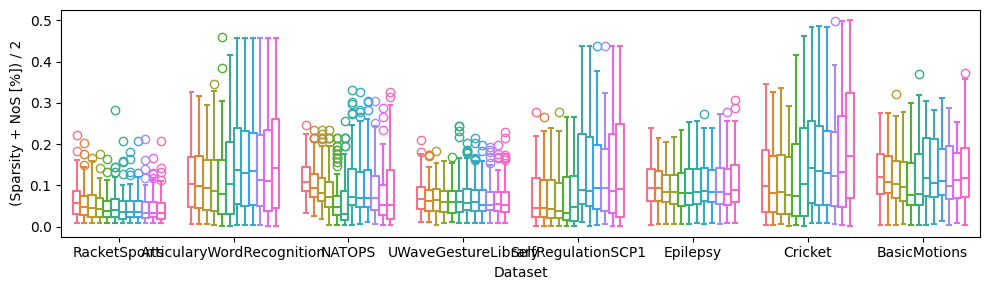

In [198]:
methods = [
    "75_0_25_ec075_ipr_0_fpr_005",
    "75_0_25_ec075_ipr_0_fpr_01",
    "75_0_25_ec075_ipr_0_fpr_015",
    "75_0_25_ec075_ipr_0_fpr_025",
    "75_0_25_ec075_ipr_0_fpr_05",
    "75_0_25_ec075_ipr_0_fpr_075",

    "0_75_25_ec075_ipr_0_fpr_005",
    "0_75_25_ec075_ipr_0_fpr_01",
    "0_75_25_ec075_ipr_0_fpr_015",
    "0_75_25_ec05_ipr_0_fpr_025",
    "0_75_25_ec05_ipr_0_fpr_05",
    "0_75_25_ec05_ipr_0_fpr_075",


    # "COMTE",
    # "AB-CF",
    # "DiscoX",
    # "MultiSub-SpaCE"
]
methods_order = dict(zip(methods, list(range(len(methods)))))

aux_df = final_df.copy()
aux_df = aux_df[aux_df['Method'].isin(methods)]
aux_df['(Sparsity + NoS [%]) / 2'] = (aux_df['Sparsity'] + aux_df['NoS [%]']) / 2
aux_df['Sparsity / NoS [%]'] = aux_df['Sparsity'] / aux_df['NoS [%]'] 
aux_df['Method_ord'] = aux_df['Method'].map( dict(zip(methods, list(range(len(methods))))) )
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values('Method_ord', ascending=True)


plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='(Sparsity + NoS [%]) / 2', hue="Method", fill=False)
# ax.legend(loc='upper right')
# plt.legend(fontsize=8)
plt.legend([],[], frameon=False)
plt.tight_layout()

In [172]:
times_df = pd.DataFrame()
for dataset in DATASETS[:-2]:
    X_train, y_train, X_test, y_test = data_dict[dataset]
    dataset_ts_len, dataset_nchannels = X_train.shape[1], X_train.shape[2]
    dataset_times = results_all_datasets_df[results_all_datasets_df["dataset"] == dataset][['times', 'method', 'dataset']]
    dataset_times["dataset_ts_len"] = dataset_ts_len
    dataset_times["dataset_nchannels"] = dataset_nchannels
    times_df = pd.concat([times_df, dataset_times])

In [173]:
times_df.groupby(["dataset", "method"]).mean()

times  dataset_ts_len  dataset_nchannels
dataset                   method                                                                   
ArticularyWordRecognition 0_75_25_ec05_ipr_0_fpr_025   71.564321           144.0                9.0
                          0_75_25_ec05_ipr_0_fpr_05    71.854349           144.0                9.0
                          0_75_25_ec05_ipr_0_fpr_075   72.364194           144.0                9.0
                          0_75_25_ec075_ipr_0_fpr_005  71.383739           144.0                9.0
                          0_75_25_ec075_ipr_0_fpr_01   71.322997           144.0                9.0
...                                                          ...             ...                ...
UWaveGestureLibrary       75_0_25_ec075_ipr_0_fpr_01   66.996986           315.0                3.0
                          75_0_25_ec075_ipr_0_fpr_015  65.926311           315.0                3.0
                          75_0_25_ec075_ipr_0_fpr_025  65.867974           315.0                3.0
                          75_0_25_ec075_ipr_0_fpr_05   66.323787           315.0                3.0
                          75_0_25_ec075_ipr_0_fpr_075  65.846912           315.0                3.0

[84 rows x 3 columns]

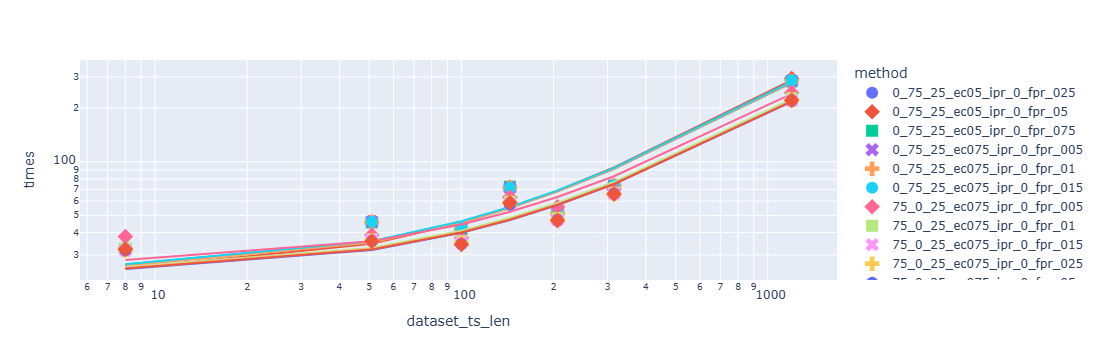

In [174]:
fig = px.scatter(
    times_df.groupby(["dataset", "method"]).mean().reset_index(), 
    x="dataset_ts_len", y="times", color="method", symbol="method", trendline="ols", log_x=True, log_y=True)
fig.update_traces(marker={'size': 12})
fig.show()

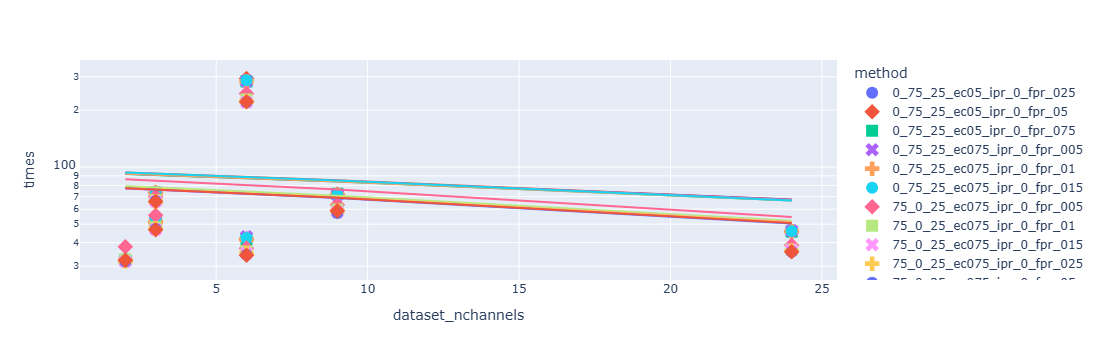

In [175]:
fig = px.scatter(
    times_df[times_df["dataset"]!="PEMS-SF"].groupby(["dataset", "method"]).mean().reset_index(), 
    x="dataset_nchannels", y="times", color="method", symbol="method", trendline="ols", log_x=False, log_y=True)
fig.update_traces(marker={'size': 12})
fig.show()

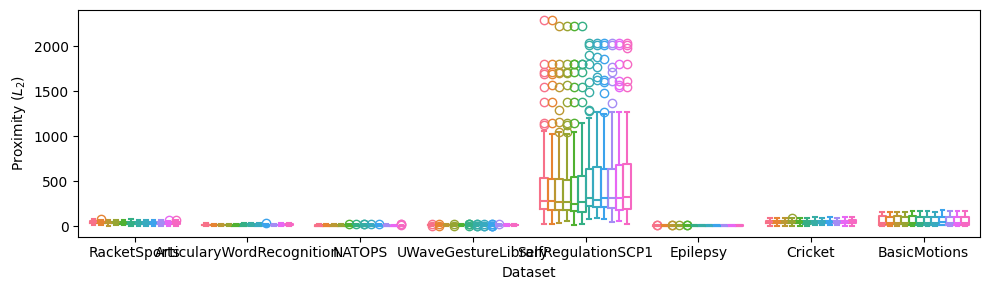

In [197]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='Proximity ($L_2$)', hue="Method", fill=False)
# ax.legend(loc='upper right')
# plt.legend(fontsize=8)
plt.legend([],[], frameon=False)
plt.tight_layout()

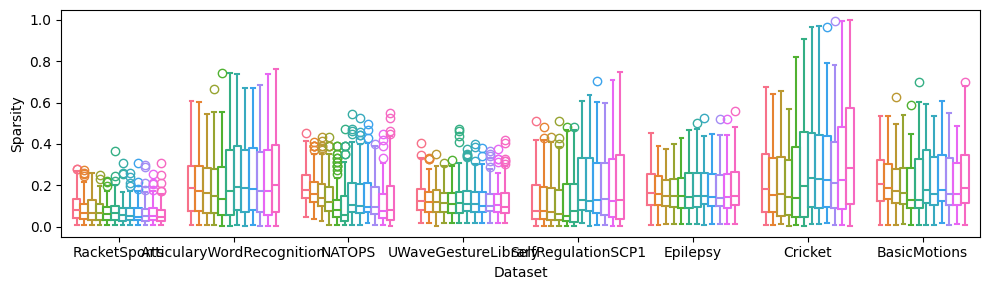

In [196]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='Sparsity', hue="Method", fill=False)
# ax.legend(loc='upper right')
# plt.legend(fontsize=8)
plt.legend([],[], frameon=False)
plt.tight_layout()

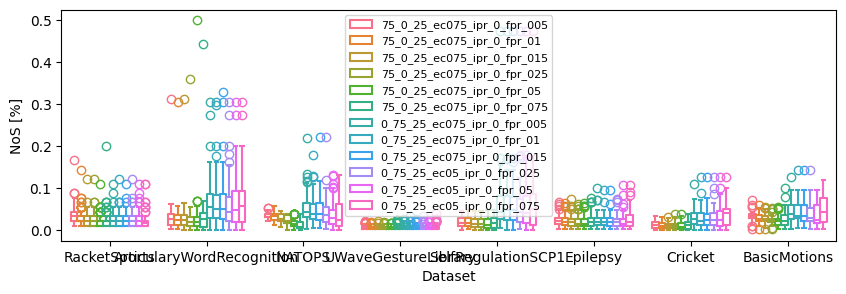

In [192]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='NoS [%]', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


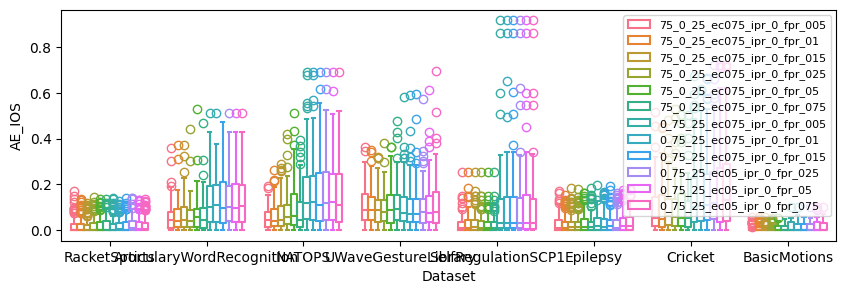

In [191]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='AE_IOS', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


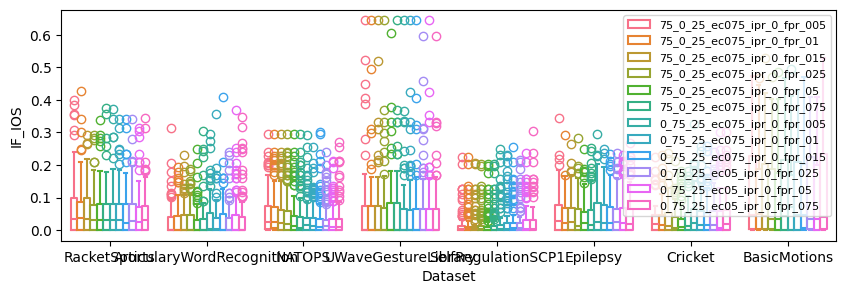

In [190]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='IF_IOS', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


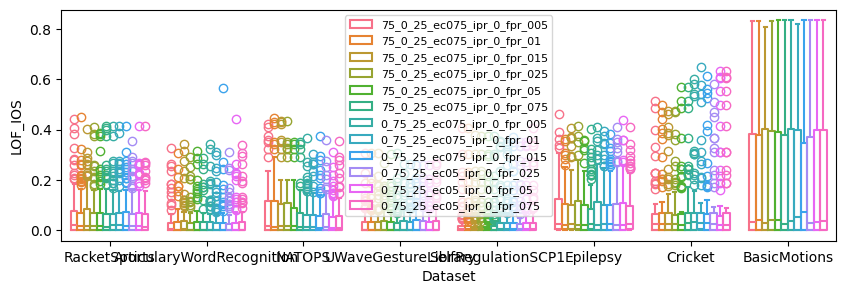

In [189]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='LOF_IOS', hue="Method", fill=False)
# ax.legend(bbox_to_anchor=(1.04, 1), loc="upper right")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))
plt.legend(fontsize=8)

# Counterfactual visualization

In [11]:
import math
def plot_comp_cfs(x_orig, possible_nuns, x_cfs_dict):
    
    # Calculate auxiliary variables
    method_names = list(x_cfs_dict.keys())
    x_cfs = list(x_cfs_dict.values())
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # Define outer grid
    fig = plt.figure(figsize=(18, 12), dpi=600)
    grid_columns = 2
    grid_rows = math.ceil(len(x_cfs) / grid_columns)
    outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0.2, hspace=0.3)

    # Iterate through outer grid plots
    for m, outer in enumerate(outer_grid):
        try:
            # Get change mask 
            x_cf = x_cfs[m]
            method_name = method_names[m]
            """# Get nuns used by the method depending on the name
            if "gknn" in method_name:
                nun_example = possible_nuns["gknn"]
            elif "iknn" in method_name:
                nun_example = possible_nuns["iknn"]
            else:
                raise ValueError('Not detected NUN finding procedure in name. Method name must contain "gknn" or "iknn"')"""
            # found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
            proximity_values = np.abs(x_orig - x_cf.reshape(1, length, n_channels))
            found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
            diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
        except IndexError:
            break
    
        # Create inner grid
        inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0.2, hspace=0.2, subplot_spec=outer)
        sub_channel_axs = []
        for i in range(n_channels):
            ax = plt.Subplot(fig, inner_grid[i])
            # ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
            ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
            ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
            # Set title if first channel
            if i == 0:
                ax.set_title(method_name)
            
            # Add fill to changes
            starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
            ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
            # Iterate over the mask segments and fill them with red color
            for i in range(0, len(starts)):
                start_idx = starts[i]
                end_idx = ends[i]
                # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
                ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            
            # Add ax to list of subplots
            fig.add_subplot(ax)
            sub_channel_axs.append(ax)

    # Plot figure
    fig.legend(
        sub_channel_axs,     # The line objects
        labels=['x_cf', 'x_orig'],   # The labels for each line
        loc='center',
        prop={'size': 12}
    )
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'./experiments/results/examples_cfs_{dataset}_instance_{instance_index}.png', dpi=600)



In [12]:
dataset = "SelfRegulationSCP1"
aux_results_dataset = results_all_datasets_df[results_all_datasets_df["dataset"]==dataset].sort_values(by="ii")

with pd.option_context("display.max_rows", None,): 
    display(aux_results_dataset[aux_results_dataset["method"]=="COMTE"])

Empty DataFrame
Columns: [ii, nchanges, sparsity, L1, L2, proba, valid, nuns_valid, outlier_score, increase_outlier_score, subsequences, subsequences %, times, method, best cf index, order, dataset]
Index: []

In [15]:
# methods = ["subspace_grouped", "subspace_v2_grouped", "subspace_individual", "subspace_v2_individual"]
common_index_instance = 0

In [16]:
# Get data
X_train, y_train, X_test, y_test = data_dict[dataset]
common_indexes = common_test_indexes_dict[dataset]
instance_index = common_indexes[common_index_instance]

# Get common cfs calculated for all method
x_orig = X_test[instance_index]

# Get possible NUNs
possible_nuns = possible_nuns_dict[dataset]
possible_nuns_instance = {type: possible_nuns[type][instance_index] for type in ["gknn", "iknn"]}

# Get original class and desired class
original_class = original_classes_dict[dataset][instance_index]
desired_class = desired_classes_dict[dataset][instance_index]

# Get the cf calculated for all methods
sol_cfs_methods = {}
sol_methods = methods_cfs_dict[dataset]
for method, solutions in sol_methods.items():
    if 'cfs' in solutions[0]:
        counterfactuals = [solution['cfs'] for solution in solutions]
    else:
        counterfactuals = [solution['cf'] for solution in solutions] 
    # Extract best counterfactual in case of multi objective
    counterfactual = counterfactuals[common_index_instance]
    # Extract best index solution
    aux_results_dataset_method = aux_results_dataset[aux_results_dataset["method"] == method]
    best_cf_index = aux_results_dataset_method.iloc[common_index_instance]["best cf index"]
    best_cf = counterfactual[best_cf_index]
    best_cf = np.expand_dims(best_cf, axis=0)
    # Append to dictionary
    sol_cfs_methods[method] = best_cf
    
# Show result
print(f'Sample {instance_index}: true class {y_test[instance_index]}, x_orig predicted {original_class}, desired_class  {desired_class}')
plot_comp_cfs(x_orig, possible_nuns_instance, sol_cfs_methods)

Sample 0: true class 1, x_orig predicted 1, desired_class  0


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:31: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:31: RuntimeWarning: invalid value encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
# Create plot with examples of each method in each dataset

In [ ]:
# CBF: 1, 2, 10, 18, 19
# chinatown: 3, 7, 19
# coffee: 1, 3, 9, 16
# ECG200: 0, 13
# gunpoint: 9, 10, 15 (pesimos en general)
dataset_samples = [('CBF', 2), ('chinatown', 19), ('coffee', 3), ('ECG200', 13), ('gunpoint', 15)]
methods_trad_dict = {"wcf_ng": "W-CF", "ng": "NG", "ab_cf": "AB-CF", "subspace": "Sub-SpaCE"}
methods = list(methods_trad_dict.keys())
include_nun_list = [False, False, False, False]

In [ ]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(16, 6))
grid_rows = len(methods)
grid_columns = len(dataset_samples)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer % grid_columns
    dataset, instance = dataset_samples[i_dataset]
    column_title = f'{dataset} instance {instance}'
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer // grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break

    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        if m == 0:
            ax.set_title(column_title)
        if i_dataset == 0:
            ax.set_ylabel(methods_trad_dict[method_name], size='large')
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    loc='lower center',
    # loc='center right',
    prop={'size': 14},
    ncol=3
)"""
# plt.show()
# plt.savefig('./experiments/results/examples_cfs.png', dpi=300)


In [ ]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(12, 12))
grid_rows = len(dataset_samples)
grid_columns = len(methods)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer // grid_columns
    dataset, instance = dataset_samples[i_dataset]
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer % grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break
    
    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        column_title = methods_trad_dict[method_name]
        # row_title = f'{dataset} \n instance {instance}'
        row_title = f'{dataset} [{instance}]'
        if m == 0:
            ax.set_ylabel(row_title, fontsize=16, rotation=90)
        if i_dataset == 0:
            ax.set_title(column_title, fontsize=18)
            
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    # loc='lower center',
    loc='center right',
    prop={'size': 18},
    ncol=1
)"""
# plt.show()
plt.savefig('./experiments/results/examples_cfs.png', dpi=300)
